In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [1]:
!pip install faiss-cpu --quiet


In [2]:
!pip -q install -U transformers

In [1]:
from huggingface_hub import login
login(new_session=False)



FIXED KERNEL (60x60) SATELLITE IMAGE RETRIEVAL SYSTEM
EXAMPLE: One-Time Dataset Processing with Fixed 60x60 Kernel
Loading DINOv3 model: facebook/dinov3-vitb16-pretrain-lvd1689m
DINOv3 model loaded. Hidden size: 768

📁 Processing 5 dataset images...
Processing dataset with fixed kernel size: (80, 80)


Processing images:   0%|          | 0/5 [00:00<?, ?it/s]

Created 336 valid 80x80 patches from 0*iRgiB6y8atMchG0o.jpg


Processing images:  20%|██        | 1/5 [00:01<00:05,  1.29s/it]

Created 0 valid 80x80 patches from 03.jpg
Created 1666 valid 80x80 patches from GC01PS03D0001.jpg


Processing images:  60%|██████    | 3/5 [00:05<00:03,  1.83s/it]

Created 1666 valid 80x80 patches from GC01PS03D0002.jpg


Processing images:  80%|████████  | 4/5 [00:09<00:02,  2.61s/it]

Created 15 valid 80x80 patches from images-2.jpg


Processing images: 100%|██████████| 5/5 [00:09<00:00,  1.92s/it]


Building index with 3683 patches, dimension 768
Building HNSW index...
Index saved to fixed_kernel_index (3 files: .index, .pkl, .json)
Dataset processing complete: 3683 patches from 5 images

✅ Dataset processing complete! Index saved for reuse.

EXAMPLE: Using Same Index with Multiple Query Images

🔍 Searching with query: 03.jpg
Query image resized from 42x42 to 80x80 to match kernel size
Extracted 1 query patches from image of size 80x80
Searching with 1 query patches...
Found 20 results. Top score: 0.6807
   Found 20 raw matches, 14 after NMS
   Top 3 scores: ['0.681', '0.526', '0.514']
Visualization saved to results_03.png


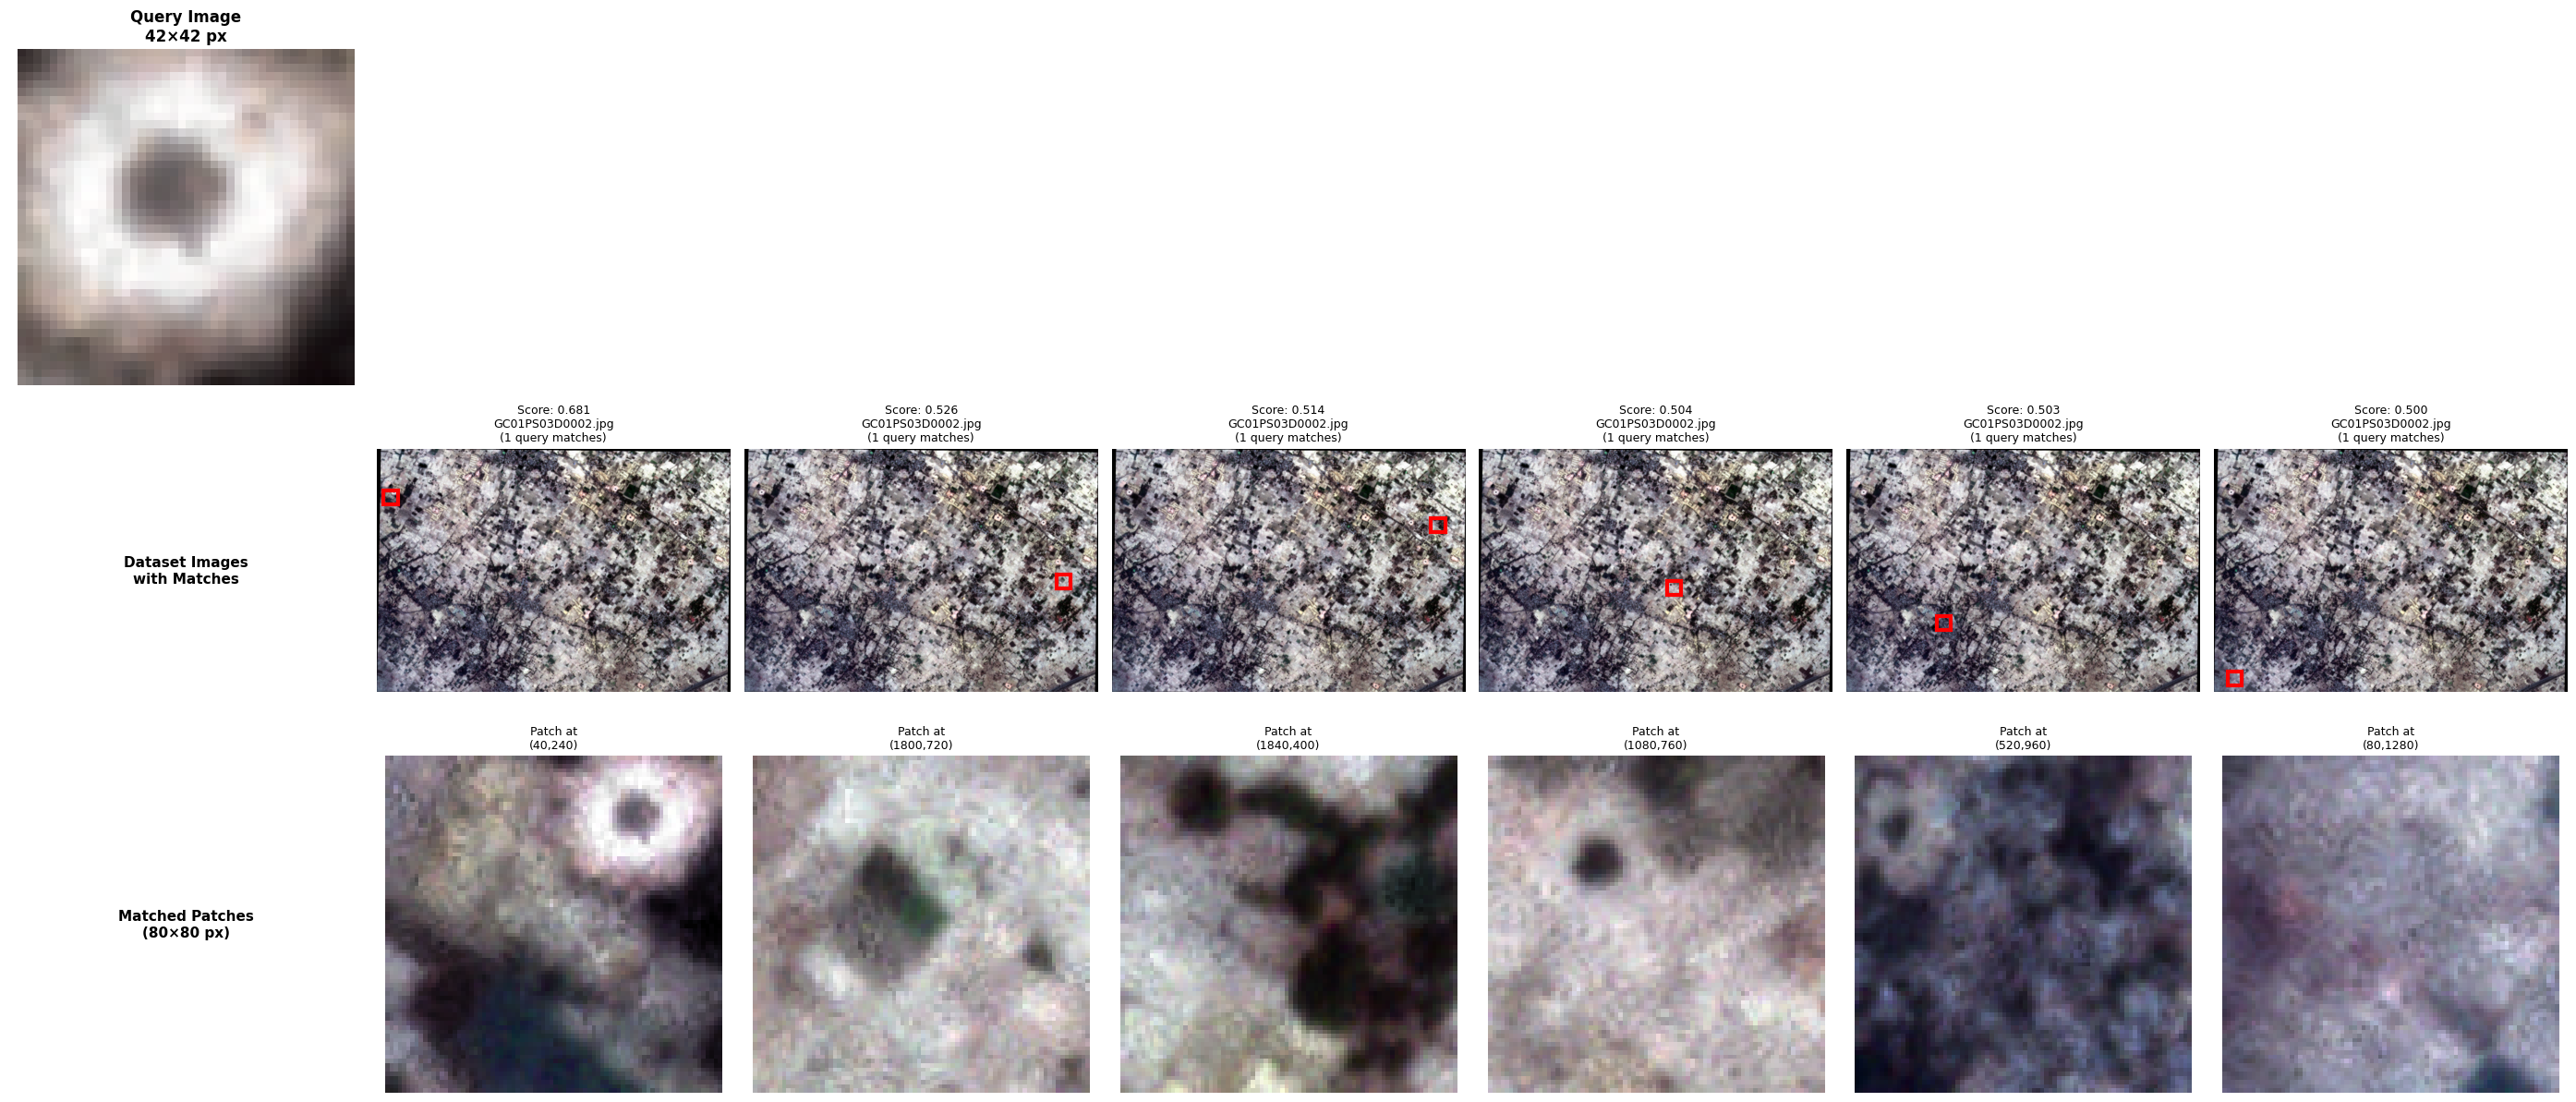


EXAMPLE: Handling Small Query Images (< 60x60)
Created small query image: (30, 30, 3)
Query image resized from 30x30 to 80x80 to match kernel size
Extracted 1 query patches from image of size 80x80
Extracted 1 patches after resizing
Patch size: 80x80
Original query size: (80, 80)

KEY BENEFITS OF FIXED KERNEL APPROACH:
✅ Process dataset only ONCE - huge time savings
✅ Consistent patch size for fair comparisons
✅ Handles any query image size automatically
✅ Efficient index storage and loading
✅ Multi-patch aggregation for better matching
✅ Suitable for production deployment


In [2]:
"""
Fixed Kernel Size (60x60) Patch-Based Query Retrieval System
=============================================================
Key Features:
1. Fixed 60x60 kernel size for all patch extractions
2. One-time dataset embedding creation that can be reused
3. Automatic query image resizing and tiling for variable input sizes
4. Multi-scale query support for better matching flexibility
"""

import os
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from typing import List, Tuple, Dict, Optional, Union, Any
from dataclasses import dataclass
from pathlib import Path
import cv2
from PIL import Image
import faiss
from tqdm import tqdm
import json
import pickle
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from collections import defaultdict
import warnings
warnings.filterwarnings('ignore')

# ---- FIXED KERNEL SIZE CONFIGURATION ----
FIXED_KERNEL_SIZE = (80, 80)  # All patches will be 60x60 pixels

# ---- dataclasses ----
@dataclass
class PatchInfo:
    """Store information about a patch"""
    image_path: str
    image_idx: int
    x: int
    y: int
    width: int
    height: int
    embedding: Optional[np.ndarray] = None

@dataclass
class RetrievalResult:
    """Store retrieval results"""
    patch_info: PatchInfo
    similarity_score: float
    query_patch_info: Optional[Dict[str, Any]] = None  # Info about which query patch matched


# ---- SatelliteModelWrapper (unchanged from original) ----
class SatelliteModelWrapper:
    """Wrapper for satellite image models with proper DINOv3 handling."""

    def __init__(self, model_name: str = "dinov3", device: str = "cuda"):
        self.device = torch.device(device if torch.cuda.is_available() else "cpu")
        self.model_name = model_name.lower()
        self.processor = None
        self.model = None
        self.preprocess = None
        self.model, self.preprocess = self._load_model()

    def _load_model(self):
        """Load the specified satellite image model with proper configuration"""
        if self.model_name == "dinov2":
            model = torch.hub.load('facebookresearch/dinov2', 'dinov2_vits14')
            model = model.to(self.device)
            model.eval()

            from torchvision import transforms
            preprocess = transforms.Compose([
                transforms.Resize(224),
                transforms.CenterCrop(224),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])
            ])

        elif self.model_name == "resnet":
            from torchvision import models, transforms
            model = models.resnet50(pretrained=True)
            model = nn.Sequential(*list(model.children())[:-1])
            model = model.to(self.device)
            model.eval()

            preprocess = transforms.Compose([
                transforms.Resize(256),
                transforms.CenterCrop(224),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])
            ])

        elif self.model_name == "dinov3":
            from transformers import AutoImageProcessor, AutoModel

            pretrained_model_name = "facebook/dinov3-vitb16-pretrain-lvd1689m"
            print(f"Loading DINOv3 model: {pretrained_model_name}")

            self.processor = AutoImageProcessor.from_pretrained(pretrained_model_name)
            model = AutoModel.from_pretrained(pretrained_model_name)
            model = model.to(self.device)
            model.eval()

            print(f"DINOv3 model loaded. Hidden size: {model.config.hidden_size}")

            def preprocess(image: Image.Image) -> Dict[str, torch.Tensor]:
                if image.mode != 'RGB':
                    image = image.convert('RGB')
                inputs = self.processor(images=image, return_tensors="pt")
                return inputs

            preprocess = preprocess

        else:
            raise ValueError(f"Unsupported model: {self.model_name}")

        return model, preprocess

    @torch.no_grad()
    def extract_features(self, images: Union[torch.Tensor, np.ndarray, Dict[str, torch.Tensor]]) -> np.ndarray:
        """Extract features with proper handling for all input types"""
        if self.model_name == "dinov3":
            if not isinstance(images, dict):
                raise ValueError("DINOv3 requires a dict input from the processor.")

            inputs = {k: v.to(self.device) for k, v in images.items()}
            outputs = self.model(**inputs)

            if hasattr(outputs, "last_hidden_state") and outputs.last_hidden_state is not None:
                cls_embeddings = outputs.last_hidden_state[:, 0]
                features = cls_embeddings
            elif hasattr(outputs, "pooler_output") and outputs.pooler_output is not None:
                features = outputs.pooler_output
            else:
                last = outputs.last_hidden_state
                features = last[:, 1:].mean(dim=1)

            features = torch.nn.functional.normalize(features, p=2, dim=1)
            return features.cpu().numpy()

        else:
            if isinstance(images, np.ndarray):
                images = torch.from_numpy(images).to(self.device)
            elif isinstance(images, torch.Tensor):
                images = images.to(self.device)
            else:
                raise ValueError("For dinov2/resnet, provide a torch.Tensor or numpy array batch.")

            features = self.model(images)

            if isinstance(features, dict):
                if 'x_norm_clstoken' in features:
                    features = features['x_norm_clstoken']
                elif 'x_norm_patchtokens' in features:
                    features = features['x_norm_patchtokens'].mean(dim=1)
                elif 'pooled' in features:
                    features = features['pooled']
                else:
                    features = features.get('last_hidden_state', features).mean(dim=1)
            else:
                if features.ndim == 4:
                    features = features.squeeze(-1).squeeze(-1)
                elif features.ndim == 2:
                    pass
                else:
                    features = features.view(features.shape[0], -1)

            if isinstance(features, torch.Tensor):
                features = torch.nn.functional.normalize(features, p=2, dim=1)

            return features.cpu().numpy()


# ---- Fixed Kernel PatchDataset ----
class FixedKernelPatchDataset(Dataset):
    """Dataset for loading patches with fixed 60x60 kernel size"""

    def __init__(self, image_path: str, kernel_size: Tuple[int, int] = FIXED_KERNEL_SIZE,
                 stride: Tuple[int, int] = None, transform=None, min_patch_std: float = 5.0):
        self.image_path = image_path
        self.kernel_size = kernel_size
        self.stride = stride if stride else (kernel_size[0] // 2, kernel_size[1] // 2)
        self.transform = transform
        self.min_patch_std = min_patch_std

        # Load image
        self.image = cv2.imread(image_path)
        if self.image is None:
            raise ValueError(f"Could not load image: {image_path}")
        self.image = cv2.cvtColor(self.image, cv2.COLOR_BGR2RGB)
        self.h, self.w = self.image.shape[:2]

        # Calculate valid patch positions
        self.patches = []
        for y in range(0, max(1, self.h - kernel_size[1] + 1), self.stride[1]):
            for x in range(0, max(1, self.w - kernel_size[0] + 1), self.stride[0]):
                patch = self.image[y:y + kernel_size[1], x:x + kernel_size[0]]

                # Only keep patches with sufficient information
                if patch.shape[0] == kernel_size[1] and patch.shape[1] == kernel_size[0]:
                    if np.std(patch) > self.min_patch_std:
                        self.patches.append((x, y))

        print(f"Created {len(self.patches)} valid {kernel_size[0]}x{kernel_size[1]} patches from {Path(image_path).name}")

    def __len__(self):
        return len(self.patches)

    def __getitem__(self, idx):
        x, y = self.patches[idx]
        patch = self.image[y:y + self.kernel_size[1], x:x + self.kernel_size[0]]

        if self.transform:
            pil = Image.fromarray(patch)
            transformed = self.transform(pil)
        else:
            pil = Image.fromarray(patch)
            transformed = pil

        return transformed, (x, y)


# ---- Query Image Handler ----
class QueryImageHandler:
    """Handle variable-sized query images with fixed kernel extraction"""

    @staticmethod
    def extract_query_patches(query_image: Union[str, np.ndarray],
                             kernel_size: Tuple[int, int] = FIXED_KERNEL_SIZE,
                             stride_ratio: float = 0.5) -> List[Dict[str, Any]]:
        """
        Extract fixed-size patches from a query image of any size.

        Returns:
            List of dictionaries containing patch info and image data
        """
        # Load query image
        if isinstance(query_image, str):
            img = cv2.imread(query_image)
            if img is None:
                raise ValueError(f"Could not load query image: {query_image}")
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        else:
            img = query_image.copy()

        h, w = img.shape[:2]
        patches = []

        # Handle case where query is smaller than kernel size
        if h < kernel_size[1] or w < kernel_size[0]:
            # Resize query to at least kernel size while maintaining aspect ratio
            scale = max(kernel_size[1] / h, kernel_size[0] / w)
            new_h, new_w = int(h * scale), int(w * scale)
            img = cv2.resize(img, (new_w, new_h), interpolation=cv2.INTER_LINEAR)
            h, w = new_h, new_h
            print(f"Query image resized from {h/scale:.0f}x{w/scale:.0f} to {h}x{w} to match kernel size")

        # Calculate stride
        stride = (max(1, int(kernel_size[0] * (1 - stride_ratio))),
                 max(1, int(kernel_size[1] * (1 - stride_ratio))))

        # Extract patches
        patch_count = 0
        for y in range(0, max(1, h - kernel_size[1] + 1), stride[1]):
            for x in range(0, max(1, w - kernel_size[0] + 1), stride[0]):
                patch = img[y:y + kernel_size[1], x:x + kernel_size[0]]

                if patch.shape[0] == kernel_size[1] and patch.shape[1] == kernel_size[0]:
                    patches.append({
                        'image': patch,
                        'x': x,
                        'y': y,
                        'width': kernel_size[0],
                        'height': kernel_size[1],
                        'patch_id': patch_count,
                        'original_size': (h, w)
                    })
                    patch_count += 1

        # If no valid patches, use the center crop
        if len(patches) == 0:
            center_x = max(0, (w - kernel_size[0]) // 2)
            center_y = max(0, (h - kernel_size[1]) // 2)
            patch = img[center_y:center_y + kernel_size[1], center_x:center_x + kernel_size[0]]

            # Pad if necessary
            if patch.shape[0] < kernel_size[1] or patch.shape[1] < kernel_size[0]:
                pad_h = max(0, kernel_size[1] - patch.shape[0])
                pad_w = max(0, kernel_size[0] - patch.shape[1])
                patch = cv2.copyMakeBorder(patch, 0, pad_h, 0, pad_w, cv2.BORDER_REFLECT)

            patches.append({
                'image': patch,
                'x': center_x,
                'y': center_y,
                'width': kernel_size[0],
                'height': kernel_size[1],
                'patch_id': 0,
                'original_size': (h, w)
            })

        print(f"Extracted {len(patches)} query patches from image of size {h}x{w}")
        return patches


# ---- Main Retrieval System ----
class FixedKernelRetrievalSystem:
    """
    Retrieval system with fixed 60x60 kernel size for all operations.
    Allows one-time dataset processing and reuse for multiple queries.
    """

    def __init__(self,
                 model_name: str = "dinov3",
                 kernel_size: Tuple[int, int] = FIXED_KERNEL_SIZE,
                 index_type: str = "auto",
                 device: str = "cuda",
                 batch_size: int = 16):
        self.model_wrapper = SatelliteModelWrapper(model_name, device)
        self.kernel_size = kernel_size
        self.index_type = index_type
        self.batch_size = batch_size
        self.index = None
        self.patch_database: List[PatchInfo] = []
        self.dimension = None
        self.query_handler = QueryImageHandler()

    def _collate_fn(self, batch: List[Tuple[Any, Tuple[int, int]]]) -> Tuple[Any, List[Tuple[int, int]]]:
        """Properly handle BatchFeature objects from HuggingFace processor"""
        patches, positions = zip(*batch)
        first = patches[0]

        if hasattr(first, 'data') and isinstance(first.data, dict):
            batched = {}
            for k in first.data.keys():
                tensors = [p.data[k] for p in patches]
                batched[k] = torch.cat(tensors, dim=0)
            return batched, list(positions)
        elif isinstance(first, dict):
            batched = {}
            for k in first.keys():
                tensors = [p[k] for p in patches]
                batched[k] = torch.cat(tensors, dim=0)
            return batched, list(positions)
        elif isinstance(first, torch.Tensor):
            batched = torch.stack(patches, dim=0)
            return batched, list(positions)
        else:
            try:
                from torchvision import transforms
                to_tensor = transforms.ToTensor()
                tensor_batch = torch.stack([
                    to_tensor(p) if not isinstance(p, torch.Tensor) else p
                    for p in patches
                ], dim=0)
                return tensor_batch, list(positions)
            except Exception as e:
                return list(patches), list(positions)

    def process_dataset(self,
                       image_paths: List[str],
                       overlap_ratio: float = 0.5,
                       save_index_path: Optional[str] = None) -> None:
        """
        Process dataset images with fixed kernel size.
        This only needs to be done once for a dataset.
        """
        print(f"Processing dataset with fixed kernel size: {self.kernel_size}")
        stride = (max(1, int(self.kernel_size[0] * (1 - overlap_ratio))),
                 max(1, int(self.kernel_size[1] * (1 - overlap_ratio))))

        all_embeddings = []

        for img_idx, img_path in enumerate(tqdm(image_paths, desc="Processing images")):
            try:
                if self.model_wrapper.model_name == "dinov3":
                    transform = lambda pil: self.model_wrapper.preprocess(pil)
                else:
                    transform = self.model_wrapper.preprocess

                # Create dataset with fixed kernel size
                dataset = FixedKernelPatchDataset(
                    img_path,
                    kernel_size=self.kernel_size,
                    stride=stride,
                    transform=transform,
                    min_patch_std=5.0
                )

                if len(dataset) == 0:
                    print(f"Warning: No valid patches in {img_path}")
                    continue

                num_workers = min(4, max(0, len(dataset) // 8))
                dataloader = DataLoader(
                    dataset,
                    batch_size=self.batch_size,
                    shuffle=False,
                    num_workers=num_workers,
                    collate_fn=self._collate_fn
                )

                for batch_patches, positions in tqdm(dataloader, desc=f"Image {img_idx+1}", leave=False):
                    try:
                        embeddings = self.model_wrapper.extract_features(batch_patches)

                        for emb, (x, y) in zip(embeddings, positions):
                            patch_info = PatchInfo(
                                image_path=img_path,
                                image_idx=img_idx,
                                x=int(x),
                                y=int(y),
                                width=self.kernel_size[0],
                                height=self.kernel_size[1],
                                embedding=emb
                            )
                            self.patch_database.append(patch_info)
                            all_embeddings.append(emb)
                    except Exception as e:
                        print(f"Error processing batch: {e}")
                        continue

            except Exception as e:
                print(f"Error processing {img_path}: {e}")
                continue

        if not all_embeddings:
            raise ValueError("No patches were successfully extracted")

        all_embeddings = np.array(all_embeddings).astype('float32')
        self.dimension = all_embeddings.shape[1]

        print(f"Building index with {len(all_embeddings)} patches, dimension {self.dimension}")
        self._build_index(all_embeddings)

        if save_index_path:
            self.save_index(save_index_path)

        print(f"Dataset processing complete: {len(self.patch_database)} patches from {len(image_paths)} images")

    def _build_index(self, embeddings: np.ndarray) -> None:
        """Build FAISS index with cosine similarity"""
        n_samples = embeddings.shape[0]

        if self.index_type == "auto":
            if n_samples < 1000:
                selected_index_type = "Flat"
            elif n_samples < 100000:
                selected_index_type = "HNSW"
            else:
                selected_index_type = "IVF_PQ"
        else:
            selected_index_type = self.index_type

        print(f"Building {selected_index_type} index...")

        if selected_index_type == "Flat":
            self.index = faiss.IndexFlatIP(self.dimension)

        elif selected_index_type == "IVF_PQ":
            nlist = max(4, min(int(np.sqrt(n_samples)), n_samples // 39))
            nlist = min(nlist, 1024)
            m = min(max(1, self.dimension // 8), 64)

            if n_samples < nlist * 39:
                print(f"Not enough samples for IVF_PQ. Using Flat index.")
                self.index = faiss.IndexFlatIP(self.dimension)
            else:
                quantizer = faiss.IndexFlatIP(self.dimension)
                self.index = faiss.IndexIVFPQ(quantizer, self.dimension, nlist, m, 8)
                self.index.train(embeddings)

        elif selected_index_type == "HNSW":
            M = 32
            self.index = faiss.IndexHNSWFlat(self.dimension, M, faiss.METRIC_INNER_PRODUCT)

        self.index.add(embeddings)

    def search_with_query(self,
                         query_image: Union[str, np.ndarray],
                         top_k: int = 10,
                         nprobe: int = 10,
                         query_stride_ratio: float = 0.5,
                         aggregation: str = "max") -> List[RetrievalResult]:
        """
        Search using a variable-sized query image.
        Extracts fixed-size patches from query and aggregates results.

        Args:
            query_image: Query image path or array
            top_k: Number of top results to return
            nprobe: Number of clusters to search (for IVF indexes)
            query_stride_ratio: Overlap ratio for query patch extraction
            aggregation: How to aggregate scores ('max', 'mean', 'weighted')
        """
        if self.index is None:
            raise ValueError("Index not built. Run process_dataset first.")

        # Extract patches from query image
        query_patches = self.query_handler.extract_query_patches(
            query_image,
            kernel_size=self.kernel_size,
            stride_ratio=query_stride_ratio
        )

        print(f"Searching with {len(query_patches)} query patches...")

        # Process each query patch
        all_results = defaultdict(lambda: {'scores': [], 'query_patches': []})

        for patch_info in query_patches:
            # Extract embedding for this patch
            patch_img = patch_info['image']

            if self.model_wrapper.model_name == "dinov3":
                pil_img = Image.fromarray(patch_img)
                inputs = self.model_wrapper.preprocess(pil_img)

                if hasattr(inputs, 'data') and isinstance(inputs.data, dict):
                    processed_inputs = {}
                    for k, v in inputs.data.items():
                        processed_inputs[k] = v
                elif isinstance(inputs, dict):
                    processed_inputs = inputs
                else:
                    raise ValueError(f"Unexpected input type: {type(inputs)}")

                embedding = self.model_wrapper.extract_features(processed_inputs)
            else:
                pil_img = Image.fromarray(patch_img)
                img_tensor = self.model_wrapper.preprocess(pil_img).unsqueeze(0)
                embedding = self.model_wrapper.extract_features(img_tensor)

            embedding = embedding.flatten().reshape(1, -1).astype('float32')

            # Search
            if hasattr(self.index, 'nprobe') and hasattr(self.index, 'nlist'):
                try:
                    self.index.nprobe = min(nprobe, self.index.nlist)
                except:
                    pass

            similarities, indices = self.index.search(embedding, top_k * 2)  # Get more to aggregate

            # Aggregate results
            for sim, idx in zip(similarities[0], indices[0]):
                if idx != -1:
                    all_results[idx]['scores'].append(float(sim))
                    all_results[idx]['query_patches'].append(patch_info)

        # Aggregate scores based on method
        final_results = []
        for idx, data in all_results.items():
            if aggregation == "max":
                final_score = max(data['scores'])
            elif aggregation == "mean":
                final_score = np.mean(data['scores'])
            elif aggregation == "weighted":
                # Weight by number of matching patches
                final_score = np.mean(data['scores']) * (1 + 0.1 * len(data['scores']))
            else:
                final_score = max(data['scores'])

            patch_info = self.patch_database[idx]
            result = RetrievalResult(
                patch_info=patch_info,
                similarity_score=final_score,
                query_patch_info={'num_matches': len(data['scores']),
                                'best_query_patch': data['query_patches'][np.argmax(data['scores'])]}
            )
            final_results.append(result)

        # Sort by score and return top k
        final_results.sort(key=lambda x: x.similarity_score, reverse=True)
        final_results = final_results[:top_k]

        print(f"Found {len(final_results)} results. Top score: {final_results[0].similarity_score:.4f}" if final_results else "No results found")
        return final_results

    def apply_nms(self, results: List[RetrievalResult], iou_threshold: float = 0.5) -> List[RetrievalResult]:
        """Apply Non-Maximum Suppression"""
        image_groups = defaultdict(list)
        for result in results:
            image_groups[result.patch_info.image_path].append(result)

        filtered_results = []
        for img_path, img_results in image_groups.items():
            img_results.sort(key=lambda x: x.similarity_score, reverse=True)
            keep = []
            for result in img_results:
                suppress = False
                for kept in keep:
                    if self._compute_iou(result.patch_info, kept.patch_info) > iou_threshold:
                        suppress = True
                        break
                if not suppress:
                    keep.append(result)
            filtered_results.extend(keep)
        return filtered_results

    def _compute_iou(self, patch1: PatchInfo, patch2: PatchInfo) -> float:
        """Compute IoU between two patches"""
        x1_min, y1_min = patch1.x, patch1.y
        x1_max, y1_max = x1_min + patch1.width, y1_min + patch1.height

        x2_min, y2_min = patch2.x, patch2.y
        x2_max, y2_max = x2_min + patch2.width, y2_min + patch2.height

        x_inter_min = max(x1_min, x2_min)
        y_inter_min = max(y1_min, y2_min)
        x_inter_max = min(x1_max, x2_max)
        y_inter_max = min(y1_max, y2_max)

        if x_inter_max <= x_inter_min or y_inter_max <= y_inter_min:
            return 0.0

        intersection = (x_inter_max - x_inter_min) * (y_inter_max - y_inter_min)
        area1 = patch1.width * patch1.height
        area2 = patch2.width * patch2.height
        union = area1 + area2 - intersection
        return intersection / union if union > 0 else 0.0

    def visualize_results(self,
                          results: List[RetrievalResult],
                          query_image: Union[str, np.ndarray],
                          num_display: int = 6,
                          save_path: Optional[str] = None) -> None:
        """Visualize retrieval results with query and matched patches"""
        if not results:
            print("No results to visualize")
            return

        num_display = min(num_display, len(results))
        fig, axes = plt.subplots(3, num_display + 1, figsize=(4 * (num_display + 1), 12))

        if axes.ndim == 1:
            axes = axes.reshape(3, -1)

        # Load query image
        if isinstance(query_image, str):
            query_img = cv2.imread(query_image)
            query_img = cv2.cvtColor(query_img, cv2.COLOR_BGR2RGB) if query_img is not None else np.zeros((60, 60, 3))
        else:
            query_img = query_image

        # Row 1: Query image
        axes[0, 0].imshow(query_img)
        axes[0, 0].set_title(f"Query Image\n{query_img.shape[1]}×{query_img.shape[0]} px",
                            fontsize=12, fontweight='bold')
        axes[0, 0].axis('off')

        for col in range(1, num_display + 1):
            axes[0, col].axis('off')

        # Row 2: Full images with boxes
        axes[1, 0].text(0.5, 0.5, "Dataset Images\nwith Matches", ha='center', va='center',
                       transform=axes[1, 0].transAxes, fontsize=11, fontweight='bold')
        axes[1, 0].axis('off')

        # Row 3: Extracted patches
        axes[2, 0].text(0.5, 0.5, f"Matched Patches\n({self.kernel_size[0]}×{self.kernel_size[1]} px)",
                       ha='center', va='center', transform=axes[2, 0].transAxes,
                       fontsize=11, fontweight='bold')
        axes[2, 0].axis('off')

        for idx, result in enumerate(results[:num_display]):
            col = idx + 1

            try:
                # Load full image
                full_img = cv2.imread(result.patch_info.image_path)
                if full_img is not None:
                    full_img = cv2.cvtColor(full_img, cv2.COLOR_BGR2RGB)
                    img_h, img_w = full_img.shape[:2]

                    # Row 2: Full image with box
                    axes[1, col].imshow(full_img)
                    rect = mpatches.Rectangle(
                        (result.patch_info.x, result.patch_info.y),
                        result.patch_info.width,
                        result.patch_info.height,
                        linewidth=3,
                        edgecolor='red',
                        facecolor='none'
                    )
                    axes[1, col].add_patch(rect)

                    # Title with match info
                    title = f"Score: {result.similarity_score:.3f}\n{Path(result.patch_info.image_path).name}"
                    if result.query_patch_info and 'num_matches' in result.query_patch_info:
                        title += f"\n({result.query_patch_info['num_matches']} query matches)"
                    axes[1, col].set_title(title, fontsize=9)
                    axes[1, col].axis('off')

                    # Row 3: Extract patch
                    patch_y_start = max(0, result.patch_info.y)
                    patch_y_end = min(img_h, result.patch_info.y + result.patch_info.height)
                    patch_x_start = max(0, result.patch_info.x)
                    patch_x_end = min(img_w, result.patch_info.x + result.patch_info.width)

                    patch = full_img[patch_y_start:patch_y_end, patch_x_start:patch_x_end]

                    if patch.size > 0:
                        axes[2, col].imshow(patch)
                        axes[2, col].set_title(f"Patch at\n({result.patch_info.x},{result.patch_info.y})", fontsize=9)
                    else:
                        axes[2, col].text(0.5, 0.5, "Empty", ha='center', va='center',
                                         transform=axes[2, col].transAxes)
                    axes[2, col].axis('off')
                else:
                    # Handle missing image
                    for row in [1, 2]:
                        axes[row, col].text(0.5, 0.5, "Image\nNot Found", ha='center', va='center',
                                           transform=axes[row, col].transAxes, color='red')
                        axes[row, col].axis('off')

            except Exception as e:
                for row in [1, 2]:
                    axes[row, col].text(0.5, 0.5, f"Error:\n{str(e)[:20]}", ha='center', va='center',
                                       transform=axes[row, col].transAxes, fontsize=8, color='red')
                    axes[row, col].axis('off')

        plt.tight_layout()
        if save_path:
            plt.savefig(save_path, dpi=150, bbox_inches='tight')
            print(f"Visualization saved to {save_path}")
        plt.show()

    def save_index(self, path: str) -> None:
        """Save the index and metadata for later reuse"""
        # Save FAISS index
        faiss.write_index(self.index, f"{path}_faiss.index")

        # Save patch database
        with open(f"{path}_patches.pkl", 'wb') as f:
            pickle.dump(self.patch_database, f)

        # Save metadata
        metadata = {
            'dimension': self.dimension,
            'kernel_size': self.kernel_size,
            'index_type': self.index_type,
            'num_patches': len(self.patch_database),
            'model_name': self.model_wrapper.model_name,
            'unique_images': len(set(p.image_path for p in self.patch_database))
        }
        with open(f"{path}_metadata.json", 'w') as f:
            json.dump(metadata, f, indent=2)

        print(f"Index saved to {path} (3 files: .index, .pkl, .json)")

    def load_index(self, path: str) -> None:
        """Load a previously saved index for reuse"""
        # Load FAISS index
        self.index = faiss.read_index(f"{path}_faiss.index")

        # Load patch database
        with open(f"{path}_patches.pkl", 'rb') as f:
            self.patch_database = pickle.load(f)

        # Load metadata
        with open(f"{path}_metadata.json", 'r') as f:
            metadata = json.load(f)
            self.dimension = metadata['dimension']
            self.kernel_size = tuple(metadata['kernel_size'])

        print(f"Index loaded: {len(self.patch_database)} patches, {metadata['unique_images']} images")


# ---- Usage Examples and Testing ----
def example_one_time_processing():
    """
    Example showing one-time dataset processing that can be reused
    """
    print("=" * 70)
    print("EXAMPLE: One-Time Dataset Processing with Fixed 60x60 Kernel")
    print("=" * 70)

    # Initialize system with fixed kernel
    system = FixedKernelRetrievalSystem(
        model_name="dinov3",  # or "dinov2", "resnet"
        kernel_size=FIXED_KERNEL_SIZE,
        index_type="auto",
        device="cuda" if torch.cuda.is_available() else "cpu",
        batch_size=16
    )

    # Process dataset ONCE
    dataset_path = Path("/home/amarjeet/Desktop/Retrieval_engine_for_satellite_images/Untitled_folder")
    dataset_images = sorted(list(dataset_path.glob("*.jpg")))[:10]  # Use subset for demo
    dataset_images = [str(p) for p in dataset_images]

    print(f"\n📁 Processing {len(dataset_images)} dataset images...")
    system.process_dataset(
        image_paths=dataset_images,
        overlap_ratio=0.5,  # 50% overlap between patches
        save_index_path="fixed_kernel_index"  # Save for later reuse
    )

    print("\n✅ Dataset processing complete! Index saved for reuse.")
    return system


def example_multiple_queries(system: Optional[FixedKernelRetrievalSystem] = None):
    """
    Example showing how to use the same index with different query images
    """
    print("\n" + "=" * 70)
    print("EXAMPLE: Using Same Index with Multiple Query Images")
    print("=" * 70)

    # If no system provided, load a saved one
    if system is None:
        system = FixedKernelRetrievalSystem(
            model_name="dinov3",
            kernel_size=FIXED_KERNEL_SIZE,
            device="cuda" if torch.cuda.is_available() else "cpu"
        )
        print("\n📂 Loading pre-computed index...")
        system.load_index("fixed_kernel_index")

    # Test with multiple query images of different sizes
    query_images = [
        "/home/amarjeet/Desktop/Retrieval_engine_for_satellite_images/Untitled_folder/03.jpg",  # Original query
        # Add more query image paths here
    ]

    for query_path in query_images:
        print(f"\n🔍 Searching with query: {Path(query_path).name}")

        # Search - handles any query size automatically
        results = system.search_with_query(
            query_image=query_path,
            top_k=20,
            nprobe=10,
            query_stride_ratio=0.3,  # More patches from query for better coverage
            aggregation="max"  # Use best matching patch score
        )

        # Apply NMS to reduce overlaps
        filtered_results = system.apply_nms(results, iou_threshold=0.3)

        print(f"   Found {len(results)} raw matches, {len(filtered_results)} after NMS")
        if filtered_results:
            print(f"   Top 3 scores: {[f'{r.similarity_score:.3f}' for r in filtered_results[:3]]}")

            # Visualize
            system.visualize_results(
                filtered_results[:6],
                query_image=query_path,
                num_display=6,
                save_path=f"results_{Path(query_path).stem}.png"
            )


def example_handle_small_query():
    """
    Example showing how the system handles queries smaller than kernel size
    """
    print("\n" + "=" * 70)
    print("EXAMPLE: Handling Small Query Images (< 60x60)")
    print("=" * 70)

    # Create a small test query (30x30)
    small_query = np.random.randint(0, 255, (30, 30, 3), dtype=np.uint8)
    print(f"Created small query image: {small_query.shape}")

    # Extract patches - will automatically resize
    handler = QueryImageHandler()
    patches = handler.extract_query_patches(small_query, FIXED_KERNEL_SIZE)

    print(f"Extracted {len(patches)} patches after resizing")
    if patches:
        print(f"Patch size: {patches[0]['width']}x{patches[0]['height']}")
        print(f"Original query size: {patches[0]['original_size']}")


def main():
    """
    Main function demonstrating the complete workflow
    """
    print("\n" + "=" * 80)
    print("FIXED KERNEL (60x60) SATELLITE IMAGE RETRIEVAL SYSTEM")
    print("=" * 80)

    # Step 1: One-time dataset processing
    system = example_one_time_processing()

    # Step 2: Use with multiple queries
    example_multiple_queries(system)

    # Step 3: Demonstrate small query handling
    example_handle_small_query()

    print("\n" + "=" * 80)
    print("KEY BENEFITS OF FIXED KERNEL APPROACH:")
    print("=" * 80)
    print("✅ Process dataset only ONCE - huge time savings")
    print("✅ Consistent patch size for fair comparisons")
    print("✅ Handles any query image size automatically")
    print("✅ Efficient index storage and loading")
    print("✅ Multi-patch aggregation for better matching")
    print("✅ Suitable for production deployment")




if __name__ == "__main__":
    # Run main workflow
    main()




ENHANCED FIXED KERNEL SATELLITE IMAGE RETRIEVAL SYSTEM
WITH PATCH COMBINING FUNCTIONALITY
EXAMPLE: One-Time Dataset Processing with Fixed 80x80 Kernel
Loading DINOv3 model: facebook/dinov3-vitb16-pretrain-lvd1689m
DINOv3 model loaded. Hidden size: 768

📁 Processing 4 dataset images...
Processing dataset with fixed kernel size: (85, 85)


Processing images:   0%|          | 0/4 [00:00<?, ?it/s]

Created 299 valid 85x85 patches from 0*iRgiB6y8atMchG0o.jpg


Processing images:  25%|██▌       | 1/4 [00:01<00:03,  1.21s/it]

Created 1504 valid 85x85 patches from GC01PS03D0001.jpg


Processing images:  50%|█████     | 2/4 [00:05<00:06,  3.12s/it]

Created 1504 valid 85x85 patches from GC01PS03D0002.jpg


Processing images:  75%|███████▌  | 3/4 [00:10<00:03,  3.76s/it]

Created 15 valid 85x85 patches from images-2.jpg


Processing images: 100%|██████████| 4/4 [00:10<00:00,  2.63s/it]


Building index with 3322 patches, dimension 768
Building HNSW index...
Index saved to fixed_kernel_index (3 files: .index, .pkl, .json)
Dataset processing complete: 3322 patches from 4 images

✅ Dataset processing complete! Index saved for reuse.

EXAMPLE: Using Same Index with Combined Patch Visualization

🔍 Searching with query: 03.png
Query image resized from 42x42 to 85x85 to match kernel size
Extracted 1 query patches from image of size 85x85
Searching with 1 query patches...
Found 30 results. Top score: 0.5859
   Found 30 raw matches, 20 after NMS
   Top 5 scores: ['0.586', '0.559', '0.544', '0.544', '0.543']

🎨 Creating traditional visualization...
Visualization saved to traditional_results_03.png


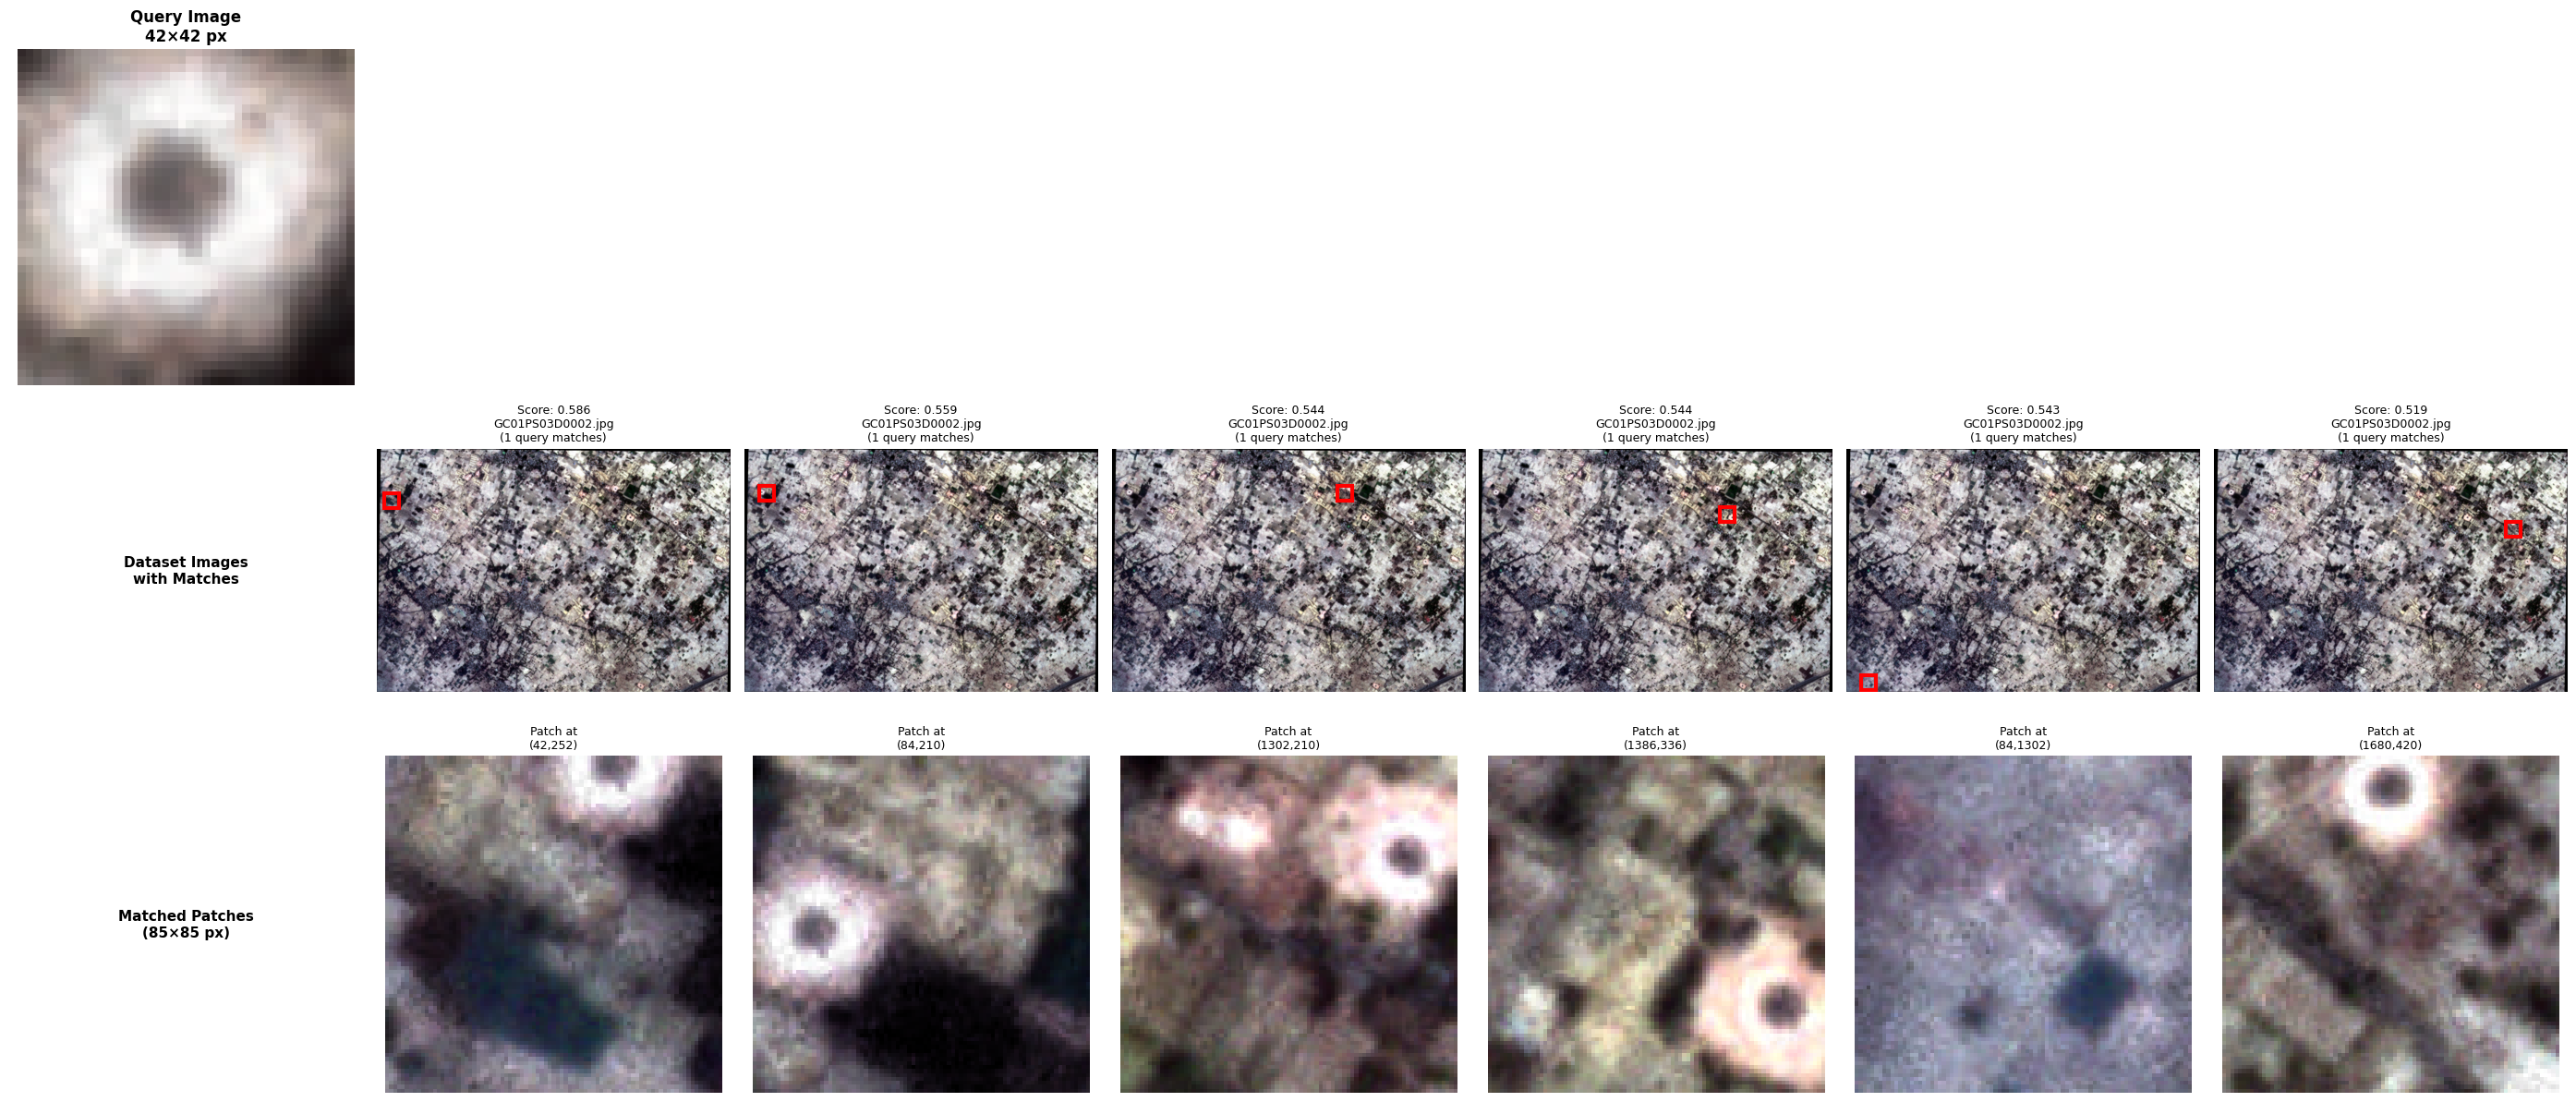


🎨 Creating COMBINED patches visualization...
Combined patches visualization saved to combined_results_03.png


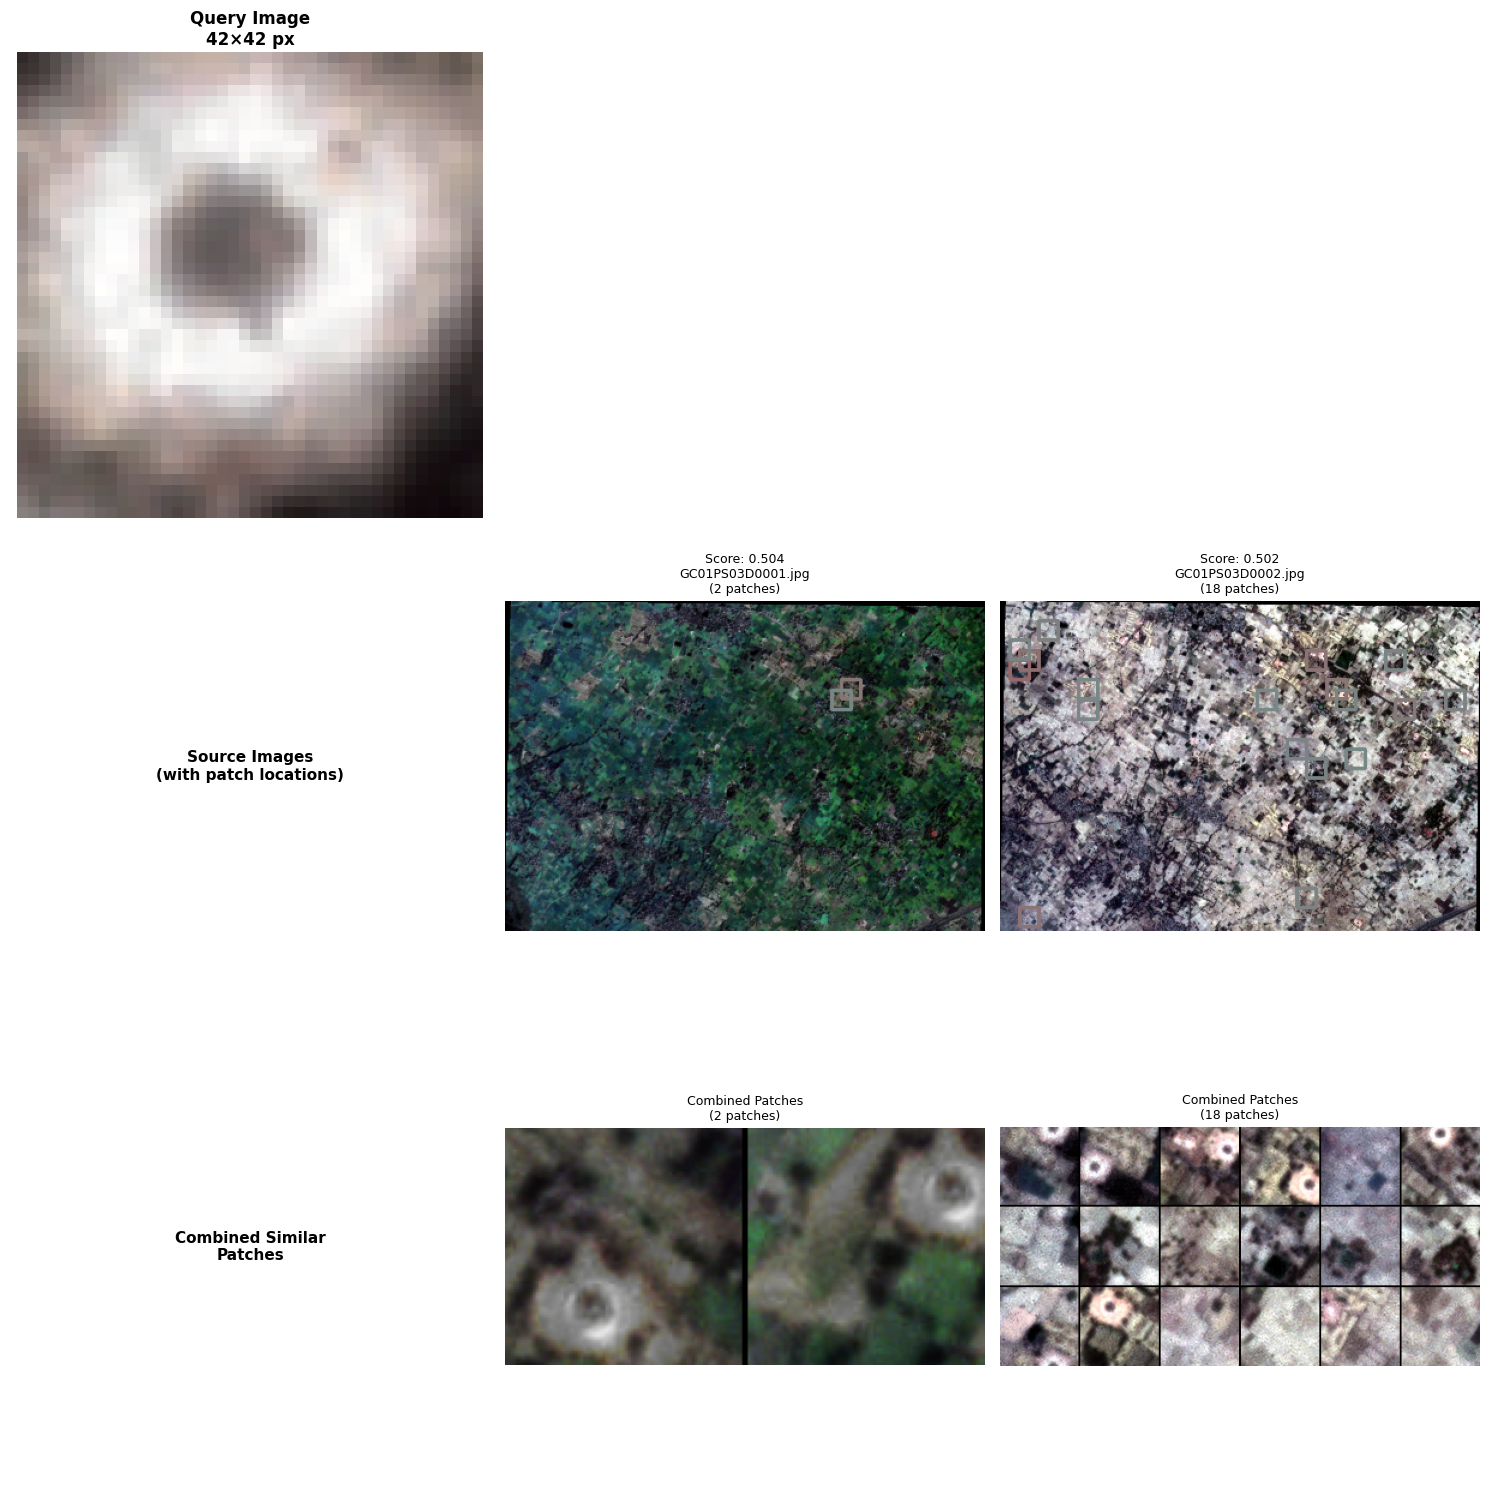


📊 Combined Patches Summary:
   Total images with matches: 2
   1. GC01PS03D0001.jpg: 2 patches, score 0.504
   2. GC01PS03D0002.jpg: 18 patches, score 0.502

💾 Saving individual combined patch images...
💾 Saving combined patches to combined_patches_03/
   ✅ GC01PS03D0002: 18 patches, score 0.502
   ✅ GC01PS03D0001: 2 patches, score 0.504
✅ Combined patch images saved to combined_patches_03/

NEW FEATURES - PATCH COMBINING:
✅ Group similar patches from same source image
✅ Create composite images showing all matches per source
✅ Overview images with patch locations highlighted
✅ Save combined patch images individually
✅ Better visualization for understanding match patterns
✅ Aggregate scoring across multiple patches per image

USAGE BENEFITS:
🔍 See ALL similar regions in each source image at once
📊 Understand which images have multiple matching areas
💾 Save clean combined patch collections for analysis
🎯 Better assessment of image-level similarity
🎨 Cleaner, more informative visualizati

In [11]:
"""
Fixed Kernel Size (60x60) Patch-Based Query Retrieval System with Patch Combining
==================================================================================
Key Features:
1. Fixed 60x60 kernel size for all patch extractions
2. One-time dataset embedding creation that can be reused
3. Automatic query image resizing and tiling for variable input sizes
4. Multi-scale query support for better matching flexibility
5. NEW: Combine similar patches from same image into composite visualizations
"""

import os
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from typing import List, Tuple, Dict, Optional, Union, Any
from dataclasses import dataclass
from pathlib import Path
import cv2
from PIL import Image
import faiss
from tqdm import tqdm
import json
import pickle
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from collections import defaultdict
import warnings
warnings.filterwarnings('ignore')



# ---- FIXED KERNEL SIZE CONFIGURATION ----
FIXED_KERNEL_SIZE = (85, 85)  # All patches will be 80x80 pixels

# ---- dataclasses ----
@dataclass
class PatchInfo:
    """Store information about a patch"""
    image_path: str
    image_idx: int
    x: int
    y: int
    width: int
    height: int
    embedding: Optional[np.ndarray] = None

@dataclass
class RetrievalResult:
    """Store retrieval results"""
    patch_info: PatchInfo
    similarity_score: float
    query_patch_info: Optional[Dict[str, Any]] = None  # Info about which query patch matched

@dataclass
class ImagePatchGroup:
    """Group of patches from the same image"""
    image_path: str
    patches: List[RetrievalResult]
    combined_score: float
    num_patches: int

# ---- SatelliteModelWrapper (unchanged from original) ----
class SatelliteModelWrapper:
    """Wrapper for satellite image models with proper DINOv3 handling."""

    def __init__(self, model_name: str = "dinov3", device: str = "cuda"):
        self.device = torch.device(device if torch.cuda.is_available() else "cpu")
        self.model_name = model_name.lower()
        self.processor = None
        self.model = None
        self.preprocess = None
        self.model, self.preprocess = self._load_model()

    def _load_model(self):
        """Load the specified satellite image model with proper configuration"""
        if self.model_name == "dinov2":
            model = torch.hub.load('facebookresearch/dinov2', 'dinov2_vits14')
            model = model.to(self.device)
            model.eval()

            from torchvision import transforms
            preprocess = transforms.Compose([
                transforms.Resize(224),
                transforms.CenterCrop(224),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])
            ])

        elif self.model_name == "resnet":
            from torchvision import models, transforms
            model = models.resnet50(pretrained=True)
            model = nn.Sequential(*list(model.children())[:-1])
            model = model.to(self.device)
            model.eval()

            preprocess = transforms.Compose([
                transforms.Resize(256),
                transforms.CenterCrop(224),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])
            ])

        elif self.model_name == "dinov3":
            from transformers import AutoImageProcessor, AutoModel

            pretrained_model_name = "facebook/dinov3-vitb16-pretrain-lvd1689m"
            # pretrained_model_name ="facebook/dinov3-vith16plus-pretrain-lvd1689m"

            print(f"Loading DINOv3 model: {pretrained_model_name}")

            self.processor = AutoImageProcessor.from_pretrained(pretrained_model_name)
            model = AutoModel.from_pretrained(pretrained_model_name)
            model = model.to(self.device)
            model.eval()

            print(f"DINOv3 model loaded. Hidden size: {model.config.hidden_size}")

            def preprocess(image: Image.Image) -> Dict[str, torch.Tensor]:
                if image.mode != 'RGB':
                    image = image.convert('RGB')
                inputs = self.processor(images=image, return_tensors="pt")
                return inputs

            preprocess = preprocess

        else:
            raise ValueError(f"Unsupported model: {self.model_name}")

        return model, preprocess

    @torch.no_grad()
    def extract_features(self, images: Union[torch.Tensor, np.ndarray, Dict[str, torch.Tensor]]) -> np.ndarray:
        """Extract features with proper handling for all input types"""
        if self.model_name == "dinov3":
            if not isinstance(images, dict):
                raise ValueError("DINOv3 requires a dict input from the processor.")

            inputs = {k: v.to(self.device) for k, v in images.items()}
            outputs = self.model(**inputs)

            if hasattr(outputs, "last_hidden_state") and outputs.last_hidden_state is not None:
                cls_embeddings = outputs.last_hidden_state[:, 0]
                features = cls_embeddings
            elif hasattr(outputs, "pooler_output") and outputs.pooler_output is not None:
                features = outputs.pooler_output
            else:
                last = outputs.last_hidden_state
                features = last[:, 1:].mean(dim=1)

            features = torch.nn.functional.normalize(features, p=2, dim=1)
            return features.cpu().numpy()

        else:
            if isinstance(images, np.ndarray):
                images = torch.from_numpy(images).to(self.device)
            elif isinstance(images, torch.Tensor):
                images = images.to(self.device)
            else:
                raise ValueError("For dinov2/resnet, provide a torch.Tensor or numpy array batch.")

            features = self.model(images)

            if isinstance(features, dict):
                if 'x_norm_clstoken' in features:
                    features = features['x_norm_clstoken']
                elif 'x_norm_patchtokens' in features:
                    features = features['x_norm_patchtokens'].mean(dim=1)
                elif 'pooled' in features:
                    features = features['pooled']
                else:
                    features = features.get('last_hidden_state', features).mean(dim=1)
            else:
                if features.ndim == 4:
                    features = features.squeeze(-1).squeeze(-1)
                elif features.ndim == 2:
                    pass
                else:
                    features = features.view(features.shape[0], -1)

            if isinstance(features, torch.Tensor):
                features = torch.nn.functional.normalize(features, p=2, dim=1)

            return features.cpu().numpy()


# ---- Fixed Kernel PatchDataset ----
class FixedKernelPatchDataset(Dataset):
    """Dataset for loading patches with fixed 60x60 kernel size"""

    def __init__(self, image_path: str, kernel_size: Tuple[int, int] = FIXED_KERNEL_SIZE,
                 stride: Tuple[int, int] = None, transform=None, min_patch_std: float = 5.0):
        self.image_path = image_path
        self.kernel_size = kernel_size
        self.stride = stride if stride else (kernel_size[0] // 2, kernel_size[1] // 2)
        self.transform = transform
        self.min_patch_std = min_patch_std

        # Load image
        self.image = cv2.imread(image_path)
        if self.image is None:
            raise ValueError(f"Could not load image: {image_path}")
        self.image = cv2.cvtColor(self.image, cv2.COLOR_BGR2RGB)
        self.h, self.w = self.image.shape[:2]

        # Calculate valid patch positions
        self.patches = []
        for y in range(0, max(1, self.h - kernel_size[1] + 1), self.stride[1]):
            for x in range(0, max(1, self.w - kernel_size[0] + 1), self.stride[0]):
                patch = self.image[y:y + kernel_size[1], x:x + kernel_size[0]]

                # Only keep patches with sufficient information
                if patch.shape[0] == kernel_size[1] and patch.shape[1] == kernel_size[0]:
                    if np.std(patch) > self.min_patch_std:
                        self.patches.append((x, y))

        print(f"Created {len(self.patches)} valid {kernel_size[0]}x{kernel_size[1]} patches from {Path(image_path).name}")

    def __len__(self):
        return len(self.patches)

    def __getitem__(self, idx):
        x, y = self.patches[idx]
        patch = self.image[y:y + self.kernel_size[1], x:x + self.kernel_size[0]]

        if self.transform:
            pil = Image.fromarray(patch)
            transformed = self.transform(pil)
        else:
            pil = Image.fromarray(patch)
            transformed = pil

        return transformed, (x, y)


# ---- Query Image Handler ----
class QueryImageHandler:
    """Handle variable-sized query images with fixed kernel extraction"""

    @staticmethod
    def extract_query_patches(query_image: Union[str, np.ndarray],
                             kernel_size: Tuple[int, int] = FIXED_KERNEL_SIZE,
                             stride_ratio: float = 0.5) -> List[Dict[str, Any]]:
        """
        Extract fixed-size patches from a query image of any size.

        Returns:
            List of dictionaries containing patch info and image data
        """
        # Load query image
        if isinstance(query_image, str):
            img = cv2.imread(query_image)
            if img is None:
                raise ValueError(f"Could not load query image: {query_image}")
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        else:
            img = query_image.copy()

        h, w = img.shape[:2]
        patches = []

        # Handle case where query is smaller than kernel size
        if h < kernel_size[1] or w < kernel_size[0]:
            # Resize query to at least kernel size while maintaining aspect ratio
            scale = max(kernel_size[1] / h, kernel_size[0] / w)
            new_h, new_w = int(h * scale), int(w * scale)
            img = cv2.resize(img, (new_w, new_h), interpolation=cv2.INTER_LINEAR)
            h, w = new_h, new_w
            print(f"Query image resized from {h/scale:.0f}x{w/scale:.0f} to {h}x{w} to match kernel size")

        # Calculate stride
        stride = (max(1, int(kernel_size[0] * (1 - stride_ratio))),
                 max(1, int(kernel_size[1] * (1 - stride_ratio))))

        # Extract patches
        patch_count = 0
        for y in range(0, max(1, h - kernel_size[1] + 1), stride[1]):
            for x in range(0, max(1, w - kernel_size[0] + 1), stride[0]):
                patch = img[y:y + kernel_size[1], x:x + kernel_size[0]]

                if patch.shape[0] == kernel_size[1] and patch.shape[1] == kernel_size[0]:
                    patches.append({
                        'image': patch,
                        'x': x,
                        'y': y,
                        'width': kernel_size[0],
                        'height': kernel_size[1],
                        'patch_id': patch_count,
                        'original_size': (h, w)
                    })
                    patch_count += 1

        # If no valid patches, use the center crop
        if len(patches) == 0:
            center_x = max(0, (w - kernel_size[0]) // 2)
            center_y = max(0, (h - kernel_size[1]) // 2)
            patch = img[center_y:center_y + kernel_size[1], center_x:center_x + kernel_size[0]]

            # Pad if necessary
            if patch.shape[0] < kernel_size[1] or patch.shape[1] < kernel_size[0]:
                pad_h = max(0, kernel_size[1] - patch.shape[0])
                pad_w = max(0, kernel_size[0] - patch.shape[1])
                patch = cv2.copyMakeBorder(patch, 0, pad_h, 0, pad_w, cv2.BORDER_REFLECT)

            patches.append({
                'image': patch,
                'x': center_x,
                'y': center_y,
                'width': kernel_size[0],
                'height': kernel_size[1],
                'patch_id': 0,
                'original_size': (h, w)
            })

        print(f"Extracted {len(patches)} query patches from image of size {h}x{w}")
        return patches


# ---- NEW: Patch Combiner Class ----
class PatchCombiner:
    """Combine similar patches from the same image into composite visualizations"""

    @staticmethod
    def group_patches_by_image(results: List[RetrievalResult]) -> Dict[str, ImagePatchGroup]:
        """Group retrieval results by source image"""
        image_groups = defaultdict(list)

        for result in results:
            image_groups[result.patch_info.image_path].append(result)

        # Create ImagePatchGroup objects
        patch_groups = {}
        for img_path, patches in image_groups.items():
            # Sort patches by score
            patches.sort(key=lambda x: x.similarity_score, reverse=True)

            # Calculate combined score (average of top scores)
            combined_score = np.mean([p.similarity_score for p in patches])

            patch_groups[img_path] = ImagePatchGroup(
                image_path=img_path,
                patches=patches,
                combined_score=combined_score,
                num_patches=len(patches)
            )

        return patch_groups

    @staticmethod
    def create_combined_patch_image(image_path: str,
                                   patches: List[RetrievalResult],
                                   kernel_size: Tuple[int, int] = FIXED_KERNEL_SIZE,
                                   max_patches_per_row: int = 6,
                                   padding: int = 2) -> np.ndarray:
        """
        Create a single image combining all patches from the same source image.

        Args:
            image_path: Path to source image
            patches: List of patch results from this image
            kernel_size: Size of each patch
            max_patches_per_row: Maximum patches per row in combined image
            padding: Padding between patches

        Returns:
            Combined image as numpy array
        """
        try:
            # Load source image
            source_img = cv2.imread(image_path)
            if source_img is None:
                # Create placeholder if image can't be loaded
                patch_h, patch_w = kernel_size
                return np.zeros((patch_h, patch_w, 3), dtype=np.uint8)

            source_img = cv2.cvtColor(source_img, cv2.COLOR_BGR2RGB)
            img_h, img_w = source_img.shape[:2]

            # Extract actual patches
            patch_images = []
            for result in patches:
                patch_info = result.patch_info

                # Extract patch with bounds checking
                y_start = max(0, patch_info.y)
                y_end = min(img_h, patch_info.y + patch_info.height)
                x_start = max(0, patch_info.x)
                x_end = min(img_w, patch_info.x + patch_info.width)

                if y_end > y_start and x_end > x_start:
                    patch = source_img[y_start:y_end, x_start:x_end]

                    # Resize to kernel size if needed
                    if patch.shape[:2] != kernel_size:
                        patch = cv2.resize(patch, kernel_size, interpolation=cv2.INTER_LINEAR)

                    patch_images.append(patch)

            if not patch_images:
                patch_h, patch_w = kernel_size
                return np.zeros((patch_h, patch_w, 3), dtype=np.uint8)

            # Calculate grid dimensions
            num_patches = len(patch_images)
            cols = min(max_patches_per_row, num_patches)
            rows = (num_patches + cols - 1) // cols

            patch_h, patch_w = kernel_size

            # Calculate combined image size
            combined_w = cols * patch_w + (cols - 1) * padding
            combined_h = rows * patch_h + (rows - 1) * padding

            # Create combined image
            combined = np.zeros((combined_h, combined_w, 3), dtype=np.uint8)

            for idx, patch in enumerate(patch_images):
                row = idx // cols
                col = idx % cols

                y_pos = row * (patch_h + padding)
                x_pos = col * (patch_w + padding)

                combined[y_pos:y_pos + patch_h, x_pos:x_pos + patch_w] = patch

            return combined

        except Exception as e:
            print(f"Error creating combined patch image for {image_path}: {e}")
            patch_h, patch_w = kernel_size
            return np.zeros((patch_h, patch_w, 3), dtype=np.uint8)

    @staticmethod
    def create_image_overview_with_patches(image_path: str,
                                         patches: List[RetrievalResult],
                                         max_size: int = 800) -> np.ndarray:
        """
        Create overview image showing source image with patch locations highlighted

        Args:
            image_path: Path to source image
            patches: List of patch results
            max_size: Maximum dimension for overview image

        Returns:
            Overview image with patches marked
        """
        try:
            # Load source image
            source_img = cv2.imread(image_path)
            if source_img is None:
                return np.zeros((max_size, max_size, 3), dtype=np.uint8)

            source_img = cv2.cvtColor(source_img, cv2.COLOR_BGR2RGB)
            orig_h, orig_w = source_img.shape[:2]

            # Resize for overview while maintaining aspect ratio
            scale = min(max_size / orig_w, max_size / orig_h)
            if scale < 1.0:
                new_w, new_h = int(orig_w * scale), int(orig_h * scale)
                overview_img = cv2.resize(source_img, (new_w, new_h), interpolation=cv2.INTER_LINEAR)
            else:
                overview_img = source_img.copy()
                scale = 1.0
                new_w, new_h = orig_w, orig_h

            # Draw patch rectangles
            for idx, result in enumerate(patches):
                patch_info = result.patch_info

                # Scale patch coordinates
                x = int(patch_info.x * scale)
                y = int(patch_info.y * scale)
                w = int(patch_info.width * scale)
                h = int(patch_info.height * scale)

                # Color based on score (high score = red, low score = blue)
                score_norm = min(1.0, max(0.0, result.similarity_score))
                color = (
                    int(255 * score_norm),      # Red component
                    int(255 * (1 - score_norm)), # Green component
                    int(255 * (1 - score_norm))  # Blue component
                )

                # Draw rectangle
                cv2.rectangle(overview_img, (x, y), (x + w, y + h), color, 2)

                # Add score text if patch is large enough
                if w > 30 and h > 20:
                    cv2.putText(overview_img, f"{result.similarity_score:.2f}",
                              (x + 2, y + 15), cv2.FONT_HERSHEY_SIMPLEX, 0.4, color, 1)

            return overview_img

        except Exception as e:
            print(f"Error creating overview for {image_path}: {e}")
            return np.zeros((max_size, max_size, 3), dtype=np.uint8)


# ---- Enhanced Main Retrieval System ----
class FixedKernelRetrievalSystem:
    """
    Retrieval system with fixed 60x60 kernel size for all operations.
    Allows one-time dataset processing and reuse for multiple queries.
    Enhanced with patch combining functionality.
    """

    def __init__(self,
                 model_name: str = "dinov3",
                 kernel_size: Tuple[int, int] = FIXED_KERNEL_SIZE,
                 index_type: str = "auto",
                 device: str = "cuda",
                 batch_size: int = 16):
        self.model_wrapper = SatelliteModelWrapper(model_name, device)
        self.kernel_size = kernel_size
        self.index_type = index_type
        self.batch_size = batch_size
        self.index = None
        self.patch_database: List[PatchInfo] = []
        self.dimension = None
        self.query_handler = QueryImageHandler()
        self.patch_combiner = PatchCombiner()

    def _collate_fn(self, batch: List[Tuple[Any, Tuple[int, int]]]) -> Tuple[Any, List[Tuple[int, int]]]:
        """Properly handle BatchFeature objects from HuggingFace processor"""
        patches, positions = zip(*batch)
        first = patches[0]

        if hasattr(first, 'data') and isinstance(first.data, dict):
            batched = {}
            for k in first.data.keys():
                tensors = [p.data[k] for p in patches]
                batched[k] = torch.cat(tensors, dim=0)
            return batched, list(positions)
        elif isinstance(first, dict):
            batched = {}
            for k in first.keys():
                tensors = [p[k] for p in patches]
                batched[k] = torch.cat(tensors, dim=0)
            return batched, list(positions)
        elif isinstance(first, torch.Tensor):
            batched = torch.stack(patches, dim=0)
            return batched, list(positions)
        else:
            try:
                from torchvision import transforms
                to_tensor = transforms.ToTensor()
                tensor_batch = torch.stack([
                    to_tensor(p) if not isinstance(p, torch.Tensor) else p
                    for p in patches
                ], dim=0)
                return tensor_batch, list(positions)
            except Exception as e:
                return list(patches), list(positions)

    def process_dataset(self,
                       image_paths: List[str],
                       overlap_ratio: float = 0.5,
                       save_index_path: Optional[str] = None) -> None:
        """
        Process dataset images with fixed kernel size.
        This only needs to be done once for a dataset.
        """
        print(f"Processing dataset with fixed kernel size: {self.kernel_size}")
        stride = (max(1, int(self.kernel_size[0] * (1 - overlap_ratio))),
                 max(1, int(self.kernel_size[1] * (1 - overlap_ratio))))

        all_embeddings = []

        for img_idx, img_path in enumerate(tqdm(image_paths, desc="Processing images")):
            try:
                if self.model_wrapper.model_name == "dinov3":
                    transform = lambda pil: self.model_wrapper.preprocess(pil)
                else:
                    transform = self.model_wrapper.preprocess

                # Create dataset with fixed kernel size
                dataset = FixedKernelPatchDataset(
                    img_path,
                    kernel_size=self.kernel_size,
                    stride=stride,
                    transform=transform,
                    min_patch_std=5.0
                )

                if len(dataset) == 0:
                    print(f"Warning: No valid patches in {img_path}")
                    continue

                num_workers = min(4, max(0, len(dataset) // 8))
                dataloader = DataLoader(
                    dataset,
                    batch_size=self.batch_size,
                    shuffle=False,
                    num_workers=num_workers,
                    collate_fn=self._collate_fn
                )

                for batch_patches, positions in tqdm(dataloader, desc=f"Image {img_idx+1}", leave=False):
                    try:
                        embeddings = self.model_wrapper.extract_features(batch_patches)

                        for emb, (x, y) in zip(embeddings, positions):
                            patch_info = PatchInfo(
                                image_path=img_path,
                                image_idx=img_idx,
                                x=int(x),
                                y=int(y),
                                width=self.kernel_size[0],
                                height=self.kernel_size[1],
                                embedding=emb
                            )
                            self.patch_database.append(patch_info)
                            all_embeddings.append(emb)
                    except Exception as e:
                        print(f"Error processing batch: {e}")
                        continue

            except Exception as e:
                print(f"Error processing {img_path}: {e}")
                continue

        if not all_embeddings:
            raise ValueError("No patches were successfully extracted")

        all_embeddings = np.array(all_embeddings).astype('float32')
        self.dimension = all_embeddings.shape[1]

        print(f"Building index with {len(all_embeddings)} patches, dimension {self.dimension}")
        self._build_index(all_embeddings)

        if save_index_path:
            self.save_index(save_index_path)

        print(f"Dataset processing complete: {len(self.patch_database)} patches from {len(image_paths)} images")

    def _build_index(self, embeddings: np.ndarray) -> None:
        """Build FAISS index with cosine similarity"""
        n_samples = embeddings.shape[0]

        if self.index_type == "auto":
            if n_samples < 1000:
                selected_index_type = "Flat"
            elif n_samples < 100000:
                selected_index_type = "HNSW"
            else:
                selected_index_type = "IVF_PQ"
        else:
            selected_index_type = self.index_type

        print(f"Building {selected_index_type} index...")

        if selected_index_type == "Flat":
            self.index = faiss.IndexFlatIP(self.dimension)

        elif selected_index_type == "IVF_PQ":
            nlist = max(4, min(int(np.sqrt(n_samples)), n_samples // 39))
            nlist = min(nlist, 1024)
            m = min(max(1, self.dimension // 8), 64)

            if n_samples < nlist * 39:
                print(f"Not enough samples for IVF_PQ. Using Flat index.")
                self.index = faiss.IndexFlatIP(self.dimension)
            else:
                quantizer = faiss.IndexFlatIP(self.dimension)
                self.index = faiss.IndexIVFPQ(quantizer, self.dimension, nlist, m, 8)
                self.index.train(embeddings)

        elif selected_index_type == "HNSW":
            M = 32
            self.index = faiss.IndexHNSWFlat(self.dimension, M, faiss.METRIC_INNER_PRODUCT)

        self.index.add(embeddings)

    def search_with_query(self,
                         query_image: Union[str, np.ndarray],
                         top_k: int = 10,
                         nprobe: int = 10,
                         query_stride_ratio: float = 0.5,
                         aggregation: str = "max") -> List[RetrievalResult]:
        """
        Search using a variable-sized query image.
        Extracts fixed-size patches from query and aggregates results.

        Args:
            query_image: Query image path or array
            top_k: Number of top results to return
            nprobe: Number of clusters to search (for IVF indexes)
            query_stride_ratio: Overlap ratio for query patch extraction
            aggregation: How to aggregate scores ('max', 'mean', 'weighted')
        """
        if self.index is None:
            raise ValueError("Index not built. Run process_dataset first.")

        # Extract patches from query image
        query_patches = self.query_handler.extract_query_patches(
            query_image,
            kernel_size=self.kernel_size,
            stride_ratio=query_stride_ratio
        )

        print(f"Searching with {len(query_patches)} query patches...")

        # Process each query patch
        all_results = defaultdict(lambda: {'scores': [], 'query_patches': []})

        for patch_info in query_patches:
            # Extract embedding for this patch
            patch_img = patch_info['image']

            if self.model_wrapper.model_name == "dinov3":
                pil_img = Image.fromarray(patch_img)
                inputs = self.model_wrapper.preprocess(pil_img)

                if hasattr(inputs, 'data') and isinstance(inputs.data, dict):
                    processed_inputs = {}
                    for k, v in inputs.data.items():
                        processed_inputs[k] = v
                elif isinstance(inputs, dict):
                    processed_inputs = inputs
                else:
                    raise ValueError(f"Unexpected input type: {type(inputs)}")

                embedding = self.model_wrapper.extract_features(processed_inputs)
            else:
                pil_img = Image.fromarray(patch_img)
                img_tensor = self.model_wrapper.preprocess(pil_img).unsqueeze(0)
                embedding = self.model_wrapper.extract_features(img_tensor)

            embedding = embedding.flatten().reshape(1, -1).astype('float32')

            # Search
            if hasattr(self.index, 'nprobe') and hasattr(self.index, 'nlist'):
                try:
                    self.index.nprobe = min(nprobe, self.index.nlist)
                except:
                    pass

            similarities, indices = self.index.search(embedding, top_k * 2)  # Get more to aggregate

            # Aggregate results
            for sim, idx in zip(similarities[0], indices[0]):
                if idx != -1:
                    all_results[idx]['scores'].append(float(sim))
                    all_results[idx]['query_patches'].append(patch_info)

        # Aggregate scores based on method
        final_results = []
        for idx, data in all_results.items():
            if aggregation == "max":
                final_score = max(data['scores'])
            elif aggregation == "mean":
                final_score = np.mean(data['scores'])
            elif aggregation == "weighted":
                # Weight by number of matching patches
                final_score = np.mean(data['scores']) * (1 + 0.1 * len(data['scores']))
            else:
                final_score = max(data['scores'])

            patch_info = self.patch_database[idx]
            result = RetrievalResult(
                patch_info=patch_info,
                similarity_score=final_score,
                query_patch_info={'num_matches': len(data['scores']),
                                'best_query_patch': data['query_patches'][np.argmax(data['scores'])]}
            )
            final_results.append(result)

        # Sort by score and return top k
        final_results.sort(key=lambda x: x.similarity_score, reverse=True)
        final_results = final_results[:top_k]

        print(f"Found {len(final_results)} results. Top score: {final_results[0].similarity_score:.4f}" if final_results else "No results found")
        return final_results

    def apply_nms(self, results: List[RetrievalResult], iou_threshold: float = 0.5) -> List[RetrievalResult]:
        """Apply Non-Maximum Suppression"""
        image_groups = defaultdict(list)
        for result in results:
            image_groups[result.patch_info.image_path].append(result)

        filtered_results = []
        for img_path, img_results in image_groups.items():
            img_results.sort(key=lambda x: x.similarity_score, reverse=True)
            keep = []
            for result in img_results:
                suppress = False
                for kept in keep:
                    if self._compute_iou(result.patch_info, kept.patch_info) > iou_threshold:
                        suppress = True
                        break
                if not suppress:
                    keep.append(result)
            filtered_results.extend(keep)
        return filtered_results

    def _compute_iou(self, patch1: PatchInfo, patch2: PatchInfo) -> float:
        """Compute IoU between two patches"""
        x1_min, y1_min = patch1.x, patch1.y
        x1_max, y1_max = x1_min + patch1.width, y1_min + patch1.height

        x2_min, y2_min = patch2.x, patch2.y
        x2_max, y2_max = x2_min + patch2.width, y2_min + patch2.height

        x_inter_min = max(x1_min, x2_min)
        y_inter_min = max(y1_min, y2_min)
        x_inter_max = min(x1_max, x2_max)
        y_inter_max = min(y1_max, y2_max)

        if x_inter_max <= x_inter_min or y_inter_max <= y_inter_min:
            return 0.0

        intersection = (x_inter_max - x_inter_min) * (y_inter_max - y_inter_min)
        area1 = patch1.width * patch1.height
        area2 = patch2.width * patch2.height
        union = area1 + area2 - intersection
        return intersection / union if union > 0 else 0.0

    def visualize_results(self,
                          results: List[RetrievalResult],
                          query_image: Union[str, np.ndarray],
                          num_display: int = 6,
                          save_path: Optional[str] = None) -> None:
        """Visualize retrieval results with query and matched patches"""
        if not results:
            print("No results to visualize")
            return

        num_display = min(num_display, len(results))
        fig, axes = plt.subplots(3, num_display + 1, figsize=(4 * (num_display + 1), 12))

        if axes.ndim == 1:
            axes = axes.reshape(3, -1)

        # Load query image
        if isinstance(query_image, str):
            query_img = cv2.imread(query_image)
            query_img = cv2.cvtColor(query_img, cv2.COLOR_BGR2RGB) if query_img is not None else np.zeros((60, 60, 3))
        else:
            query_img = query_image

        # Row 1: Query image
        axes[0, 0].imshow(query_img)
        axes[0, 0].set_title(f"Query Image\n{query_img.shape[1]}×{query_img.shape[0]} px",
                            fontsize=12, fontweight='bold')
        axes[0, 0].axis('off')

        for col in range(1, num_display + 1):
            axes[0, col].axis('off')

        # Row 2: Full images with boxes
        axes[1, 0].text(0.5, 0.5, "Dataset Images\nwith Matches", ha='center', va='center',
                       transform=axes[1, 0].transAxes, fontsize=11, fontweight='bold')
        axes[1, 0].axis('off')

        # Row 3: Extracted patches
        axes[2, 0].text(0.5, 0.5, f"Matched Patches\n({self.kernel_size[0]}×{self.kernel_size[1]} px)",
                       ha='center', va='center', transform=axes[2, 0].transAxes,
                       fontsize=11, fontweight='bold')
        axes[2, 0].axis('off')

        for idx, result in enumerate(results[:num_display]):
            col = idx + 1

            try:
                # Load full image
                full_img = cv2.imread(result.patch_info.image_path)
                if full_img is not None:
                    full_img = cv2.cvtColor(full_img, cv2.COLOR_BGR2RGB)
                    img_h, img_w = full_img.shape[:2]

                    # Row 2: Full image with box
                    axes[1, col].imshow(full_img)
                    rect = mpatches.Rectangle(
                        (result.patch_info.x, result.patch_info.y),
                        result.patch_info.width,
                        result.patch_info.height,
                        linewidth=3,
                        edgecolor='red',
                        facecolor='none'
                    )
                    axes[1, col].add_patch(rect)

                    # Title with match info
                    title = f"Score: {result.similarity_score:.3f}\n{Path(result.patch_info.image_path).name}"
                    if result.query_patch_info and 'num_matches' in result.query_patch_info:
                        title += f"\n({result.query_patch_info['num_matches']} query matches)"
                    axes[1, col].set_title(title, fontsize=9)
                    axes[1, col].axis('off')

                    # Row 3: Extract patch
                    patch_y_start = max(0, result.patch_info.y)
                    patch_y_end = min(img_h, result.patch_info.y + result.patch_info.height)
                    patch_x_start = max(0, result.patch_info.x)
                    patch_x_end = min(img_w, result.patch_info.x + result.patch_info.width)

                    patch = full_img[patch_y_start:patch_y_end, patch_x_start:patch_x_end]

                    if patch.size > 0:
                        axes[2, col].imshow(patch)
                        axes[2, col].set_title(f"Patch at\n({result.patch_info.x},{result.patch_info.y})", fontsize=9)
                    else:
                        axes[2, col].text(0.5, 0.5, "Empty", ha='center', va='center',
                                         transform=axes[2, col].transAxes)
                    axes[2, col].axis('off')
                else:
                    # Handle missing image
                    for row in [1, 2]:
                        axes[row, col].text(0.5, 0.5, "Image\nNot Found", ha='center', va='center',
                                           transform=axes[row, col].transAxes, color='red')
                        axes[row, col].axis('off')

            except Exception as e:
                for row in [1, 2]:
                    axes[row, col].text(0.5, 0.5, f"Error:\n{str(e)[:20]}", ha='center', va='center',
                                       transform=axes[row, col].transAxes, fontsize=8, color='red')
                    axes[row, col].axis('off')

        plt.tight_layout()
        if save_path:
            plt.savefig(save_path, dpi=150, bbox_inches='tight')
            print(f"Visualization saved to {save_path}")
        plt.show()

    def visualize_combined_patches(self,
                                  results: List[RetrievalResult],
                                  query_image: Union[str, np.ndarray],
                                  max_images_to_show: int = 6,
                                  save_path: Optional[str] = None) -> None:
        """
        NEW: Visualize results with combined patches from each image

        Args:
            results: List of retrieval results
            query_image: Query image
            max_images_to_show: Maximum number of source images to display
            save_path: Path to save visualization
        """
        if not results:
            print("No results to visualize")
            return

        # Group patches by image
        image_groups = self.patch_combiner.group_patches_by_image(results)

        # Sort by combined score and take top images
        sorted_groups = sorted(image_groups.values(),
                             key=lambda x: x.combined_score, reverse=True)
        sorted_groups = sorted_groups[:max_images_to_show]

        num_images = len(sorted_groups)

        # Create figure: Query + Overview + Combined patches for each image
        fig, axes = plt.subplots(3, num_images + 1, figsize=(5 * (num_images + 1), 15))

        if axes.ndim == 1:
            axes = axes.reshape(3, -1)

        # Load and display query image
        if isinstance(query_image, str):
            query_img = cv2.imread(query_image)
            query_img = cv2.cvtColor(query_img, cv2.COLOR_BGR2RGB) if query_img is not None else np.zeros((100, 100, 3))
        else:
            query_img = query_image

        # Column 0: Query and labels
        axes[0, 0].imshow(query_img)
        axes[0, 0].set_title(f"Query Image\n{query_img.shape[1]}×{query_img.shape[0]} px",
                            fontsize=12, fontweight='bold')
        axes[0, 0].axis('off')

        axes[1, 0].text(0.5, 0.5, "Source Images\n(with patch locations)",
                       ha='center', va='center', transform=axes[1, 0].transAxes,
                       fontsize=11, fontweight='bold')
        axes[1, 0].axis('off')

        axes[2, 0].text(0.5, 0.5, "Combined Similar\nPatches",
                       ha='center', va='center', transform=axes[2, 0].transAxes,
                       fontsize=11, fontweight='bold')
        axes[2, 0].axis('off')

        # Process each image group
        for col_idx, group in enumerate(sorted_groups):
            col = col_idx + 1

            try:
                # Row 1: Empty for query row alignment
                axes[0, col].axis('off')

                # Row 2: Overview image with patch locations
                overview_img = self.patch_combiner.create_image_overview_with_patches(
                    group.image_path, group.patches, max_size=400
                )

                axes[1, col].imshow(overview_img)
                title = f"Score: {group.combined_score:.3f}\n{Path(group.image_path).name}\n({group.num_patches} patches)"
                axes[1, col].set_title(title, fontsize=9)
                axes[1, col].axis('off')

                # Row 3: Combined patch image
                combined_patches = self.patch_combiner.create_combined_patch_image(
                    group.image_path, group.patches, self.kernel_size, max_patches_per_row=6
                )

                axes[2, col].imshow(combined_patches)
                axes[2, col].set_title(f"Combined Patches\n({group.num_patches} patches)", fontsize=9)
                axes[2, col].axis('off')

            except Exception as e:
                print(f"Error visualizing group for {group.image_path}: {e}")
                for row in [1, 2]:
                    axes[row, col].text(0.5, 0.5, f"Error:\n{str(e)[:20]}",
                                       ha='center', va='center', transform=axes[row, col].transAxes,
                                       fontsize=8, color='red')
                    axes[row, col].axis('off')

        plt.tight_layout()
        if save_path:
            plt.savefig(save_path, dpi=150, bbox_inches='tight')
            print(f"Combined patches visualization saved to {save_path}")
        plt.show()

        # Print summary
        print(f"\n📊 Combined Patches Summary:")
        print(f"   Total images with matches: {len(sorted_groups)}")
        for i, group in enumerate(sorted_groups, 1):
            print(f"   {i}. {Path(group.image_path).name}: {group.num_patches} patches, score {group.combined_score:.3f}")

    def save_combined_patches_separately(self,
                                       results: List[RetrievalResult],
                                       output_dir: str = "combined_patches") -> None:
        """
        NEW: Save combined patch images for each source image separately

        Args:
            results: List of retrieval results
            output_dir: Directory to save combined patch images
        """
        output_path = Path(output_dir)
        output_path.mkdir(exist_ok=True)

        # Group patches by image
        image_groups = self.patch_combiner.group_patches_by_image(results)

        print(f"💾 Saving combined patches to {output_dir}/")

        for img_path, group in image_groups.items():
            try:
                # Create combined patch image
                combined_img = self.patch_combiner.create_combined_patch_image(
                    img_path, group.patches, self.kernel_size, max_patches_per_row=8
                )

                # Save combined image
                img_name = Path(img_path).stem
                save_path = output_path / f"{img_name}_combined_{group.num_patches}patches.jpg"

                combined_img_bgr = cv2.cvtColor(combined_img, cv2.COLOR_RGB2BGR)
                cv2.imwrite(str(save_path), combined_img_bgr)

                print(f"   ✅ {img_name}: {group.num_patches} patches, score {group.combined_score:.3f}")

            except Exception as e:
                print(f"   ❌ Error saving {Path(img_path).name}: {e}")

        print(f"✅ Combined patch images saved to {output_dir}/")

    def save_index(self, path: str) -> None:
        """Save the index and metadata for later reuse"""
        # Save FAISS index
        faiss.write_index(self.index, f"{path}_faiss.index")

        # Save patch database
        with open(f"{path}_patches.pkl", 'wb') as f:
            pickle.dump(self.patch_database, f)

        # Save metadata
        metadata = {
            'dimension': self.dimension,
            'kernel_size': self.kernel_size,
            'index_type': self.index_type,
            'num_patches': len(self.patch_database),
            'model_name': self.model_wrapper.model_name,
            'unique_images': len(set(p.image_path for p in self.patch_database))
        }
        with open(f"{path}_metadata.json", 'w') as f:
            json.dump(metadata, f, indent=2)

        print(f"Index saved to {path} (3 files: .index, .pkl, .json)")

    def load_index(self, path: str) -> None:
        """Load a previously saved index for reuse"""
        # Load FAISS index
        self.index = faiss.read_index(f"{path}_faiss.index")

        # Load patch database
        with open(f"{path}_patches.pkl", 'rb') as f:
            self.patch_database = pickle.load(f)

        # Load metadata
        with open(f"{path}_metadata.json", 'r') as f:
            metadata = json.load(f)
            self.dimension = metadata['dimension']
            self.kernel_size = tuple(metadata['kernel_size'])

        print(f"Index loaded: {len(self.patch_database)} patches, {metadata['unique_images']} images")


# ---- Usage Examples and Testing ----
def example_one_time_processing():
    """
    Example showing one-time dataset processing that can be reused
    """
    print("=" * 70)
    print("EXAMPLE: One-Time Dataset Processing with Fixed 80x80 Kernel")
    print("=" * 70)

    # Initialize system with fixed kernel
    system = FixedKernelRetrievalSystem(
        model_name="dinov3",  # or "dinov2", "resnet"
        kernel_size=FIXED_KERNEL_SIZE,
        index_type="auto",
        device="cuda" if torch.cuda.is_available() else "cpu",
        batch_size=16
    )

    # Process dataset ONCE
    dataset_path = Path("/home/amarjeet/Desktop/Retrieval_engine_for_satellite_images/Untitled_folder")
    dataset_images = sorted(list(dataset_path.glob("*.jpg")))[:10]  # Use subset for demo
    dataset_images = [str(p) for p in dataset_images]

    print(f"\n📁 Processing {len(dataset_images)} dataset images...")
    system.process_dataset(
        image_paths=dataset_images,
        overlap_ratio=0.5,  # 50% overlap between patches
        save_index_path="fixed_kernel_index"  # Save for later reuse
    )

    print("\n✅ Dataset processing complete! Index saved for reuse.")
    return system


def example_multiple_queries_with_combining(system: Optional[FixedKernelRetrievalSystem] = None):
    """
    NEW: Example showing combined patch visualization
    """
    print("\n" + "=" * 70)
    print("EXAMPLE: Using Same Index with Combined Patch Visualization")
    print("=" * 70)

    # If no system provided, load a saved one
    if system is None:
        system = FixedKernelRetrievalSystem(
            model_name="dinov3",
            kernel_size=FIXED_KERNEL_SIZE,
            device="cuda" if torch.cuda.is_available() else "cpu"
        )
        print("\n📂 Loading pre-computed index...")
        system.load_index("fixed_kernel_index")

    # Test with query image
    query_path = "/home/amarjeet/Desktop/Retrieval_engine_for_satellite_images/Untitled_folder/03.png"

    print(f"\n🔍 Searching with query: {Path(query_path).name}")

    # Search - handles any query size automatically
    results = system.search_with_query(
        query_image=query_path,
        top_k=30,  # Get more results for better combining
        nprobe=10,
        query_stride_ratio=0.3,
        aggregation="max"
    )

    # Apply NMS to reduce overlaps
    filtered_results = system.apply_nms(results, iou_threshold=0.3)

    print(f"   Found {len(results)} raw matches, {len(filtered_results)} after NMS")

    if filtered_results:
        print(f"   Top 5 scores: {[f'{r.similarity_score:.3f}' for r in filtered_results[:5]]}")

        # Traditional visualization
        print("\n🎨 Creating traditional visualization...")
        system.visualize_results(
            filtered_results[:6],
            query_image=query_path,
            num_display=6,
            save_path=f"traditional_results_{Path(query_path).stem}.png"
        )

        # NEW: Combined patches visualization
        print("\n🎨 Creating COMBINED patches visualization...")
        system.visualize_combined_patches(
            filtered_results,
            query_image=query_path,
            max_images_to_show=5,
            save_path=f"combined_results_{Path(query_path).stem}.png"
        )

        # NEW: Save combined patches separately
        print("\n💾 Saving individual combined patch images...")
        system.save_combined_patches_separately(
            filtered_results,
            output_dir=f"combined_patches_{Path(query_path).stem}"
        )


def main():
    """
    Main function demonstrating the complete workflow with new patch combining features
    """
    print("\n" + "=" * 80)
    print("ENHANCED FIXED KERNEL SATELLITE IMAGE RETRIEVAL SYSTEM")
    print("WITH PATCH COMBINING FUNCTIONALITY")
    print("=" * 80)

    # Step 1: One-time dataset processing
    system = example_one_time_processing()

    # Step 2: Use with combined patch visualization
    example_multiple_queries_with_combining(system)

    print("\n" + "=" * 80)
    print("NEW FEATURES - PATCH COMBINING:")
    print("=" * 80)
    print("✅ Group similar patches from same source image")
    print("✅ Create composite images showing all matches per source")
    print("✅ Overview images with patch locations highlighted")
    print("✅ Save combined patch images individually")
    print("✅ Better visualization for understanding match patterns")
    print("✅ Aggregate scoring across multiple patches per image")

    print("\n" + "=" * 80)
    print("USAGE BENEFITS:")
    print("=" * 80)
    print("🔍 See ALL similar regions in each source image at once")
    print("📊 Understand which images have multiple matching areas")
    print("💾 Save clean combined patch collections for analysis")
    print("🎯 Better assessment of image-level similarity")
    print("🎨 Cleaner, more informative visualizations")


if __name__ == "__main__":
    # Run main workflow with new patch combining features
    main()

Loading DINOv3 model: facebook/dinov3-vitb16-pretrain-lvd1689m
DINOv3 model loaded. Hidden size: 768
Index loaded: 3322 patches, 4 images
Query image resized from 50x50 to 85x85 to match kernel size
Extracted 1 query patches from image of size 85x85
Searching with 1 query patches...
Found 25 results. Top score: 0.5042


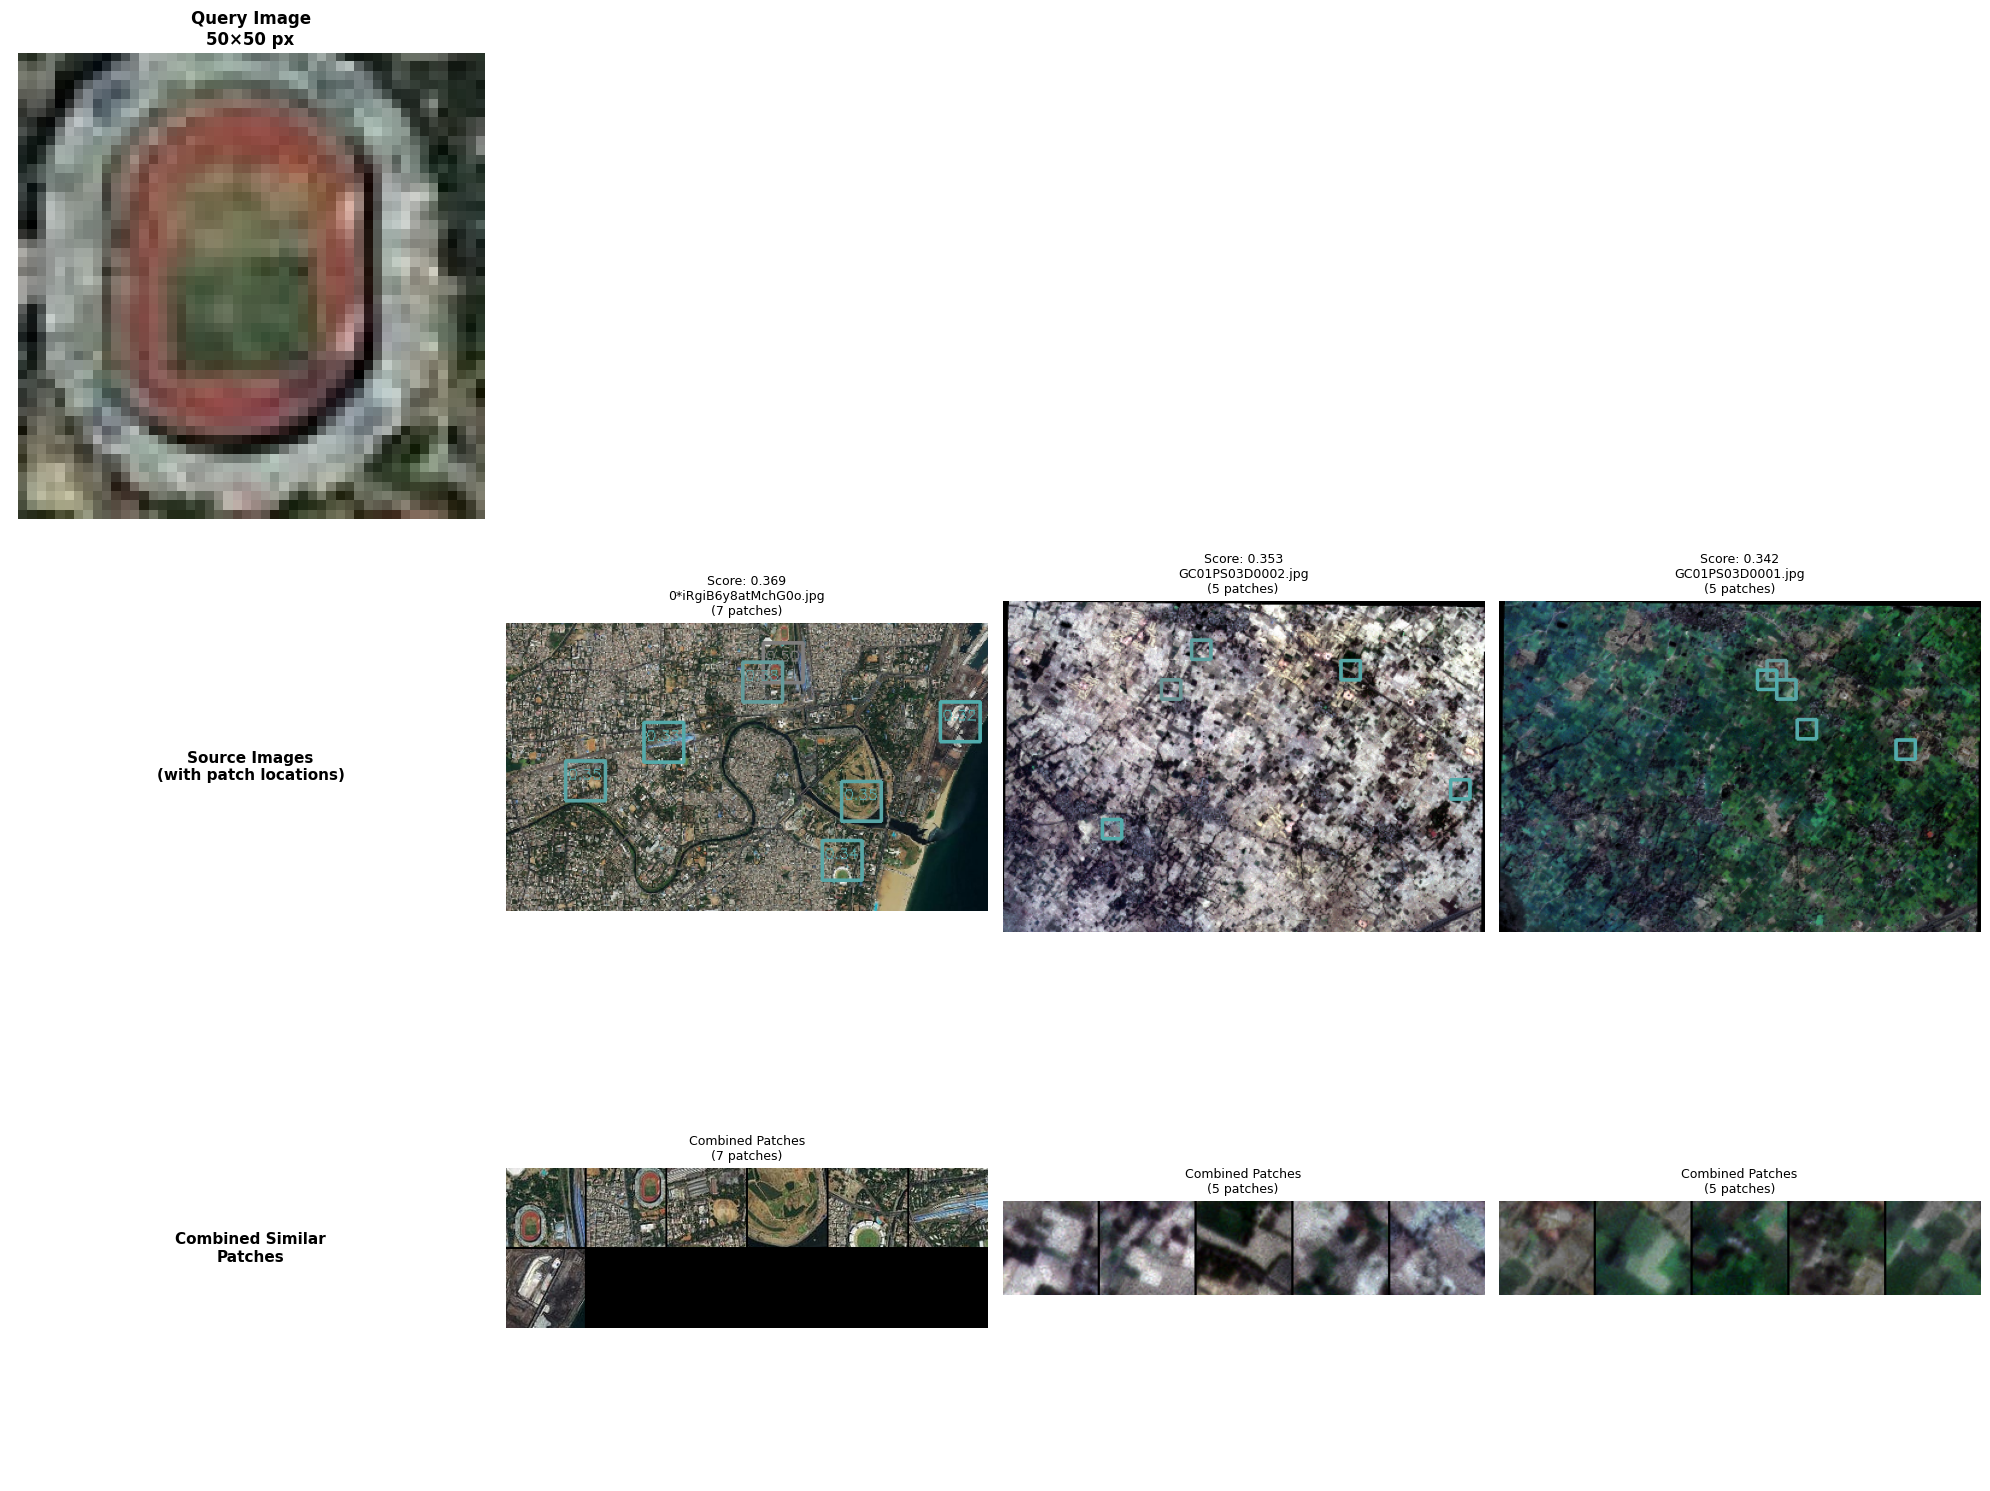


📊 Combined Patches Summary:
   Total images with matches: 3
   1. 0*iRgiB6y8atMchG0o.jpg: 7 patches, score 0.369
   2. GC01PS03D0002.jpg: 5 patches, score 0.353
   3. GC01PS03D0001.jpg: 5 patches, score 0.342


In [15]:
from PIL import Image

def quick_query_with_saved_index(query_image_path: str, index_path: str = "fixed_kernel_index"):
    """Quick function to query using pre-computed index"""

    # ---- Step 1: Compress query image to 50x50 ----
    compressed_path = query_image_path.replace(".png", "_compressed.png")
    with Image.open(query_image_path) as img:
        img = img.resize((50, 50), Image.Resampling.LANCZOS)
        img.save(compressed_path)

    # ---- Step 2: Load system with saved index ----
    system = FixedKernelRetrievalSystem(model_name="dinov3")
    system.load_index(index_path)

    # ---- Step 3: Search ----
    results = system.search_with_query(compressed_path, top_k=25)
    filtered_results = system.apply_nms(results, iou_threshold=0.3)

    # ---- Step 4: Visualize with combined patches ----
    system.visualize_combined_patches(
        filtered_results,
        query_image=compressed_path,
        max_images_to_show=5
    )

    return filtered_results

# Example usage:
results = quick_query_with_saved_index(
    "/home/amarjeet/Desktop/Retrieval_engine_for_satellite_images/Untitled_folder/01.png"
)


Loading DINOv3 model: facebook/dinov3-vitb16-pretrain-lvd1689m
DINOv3 model loaded. Hidden size: 768
Index loaded: 3322 patches, 4 images
Query image resized from 87x77 to 95x84 to match kernel size
Extracted 1 query patches from image of size 95x84
Searching with 1 query patches...
Found 25 results. Top score: 0.3154


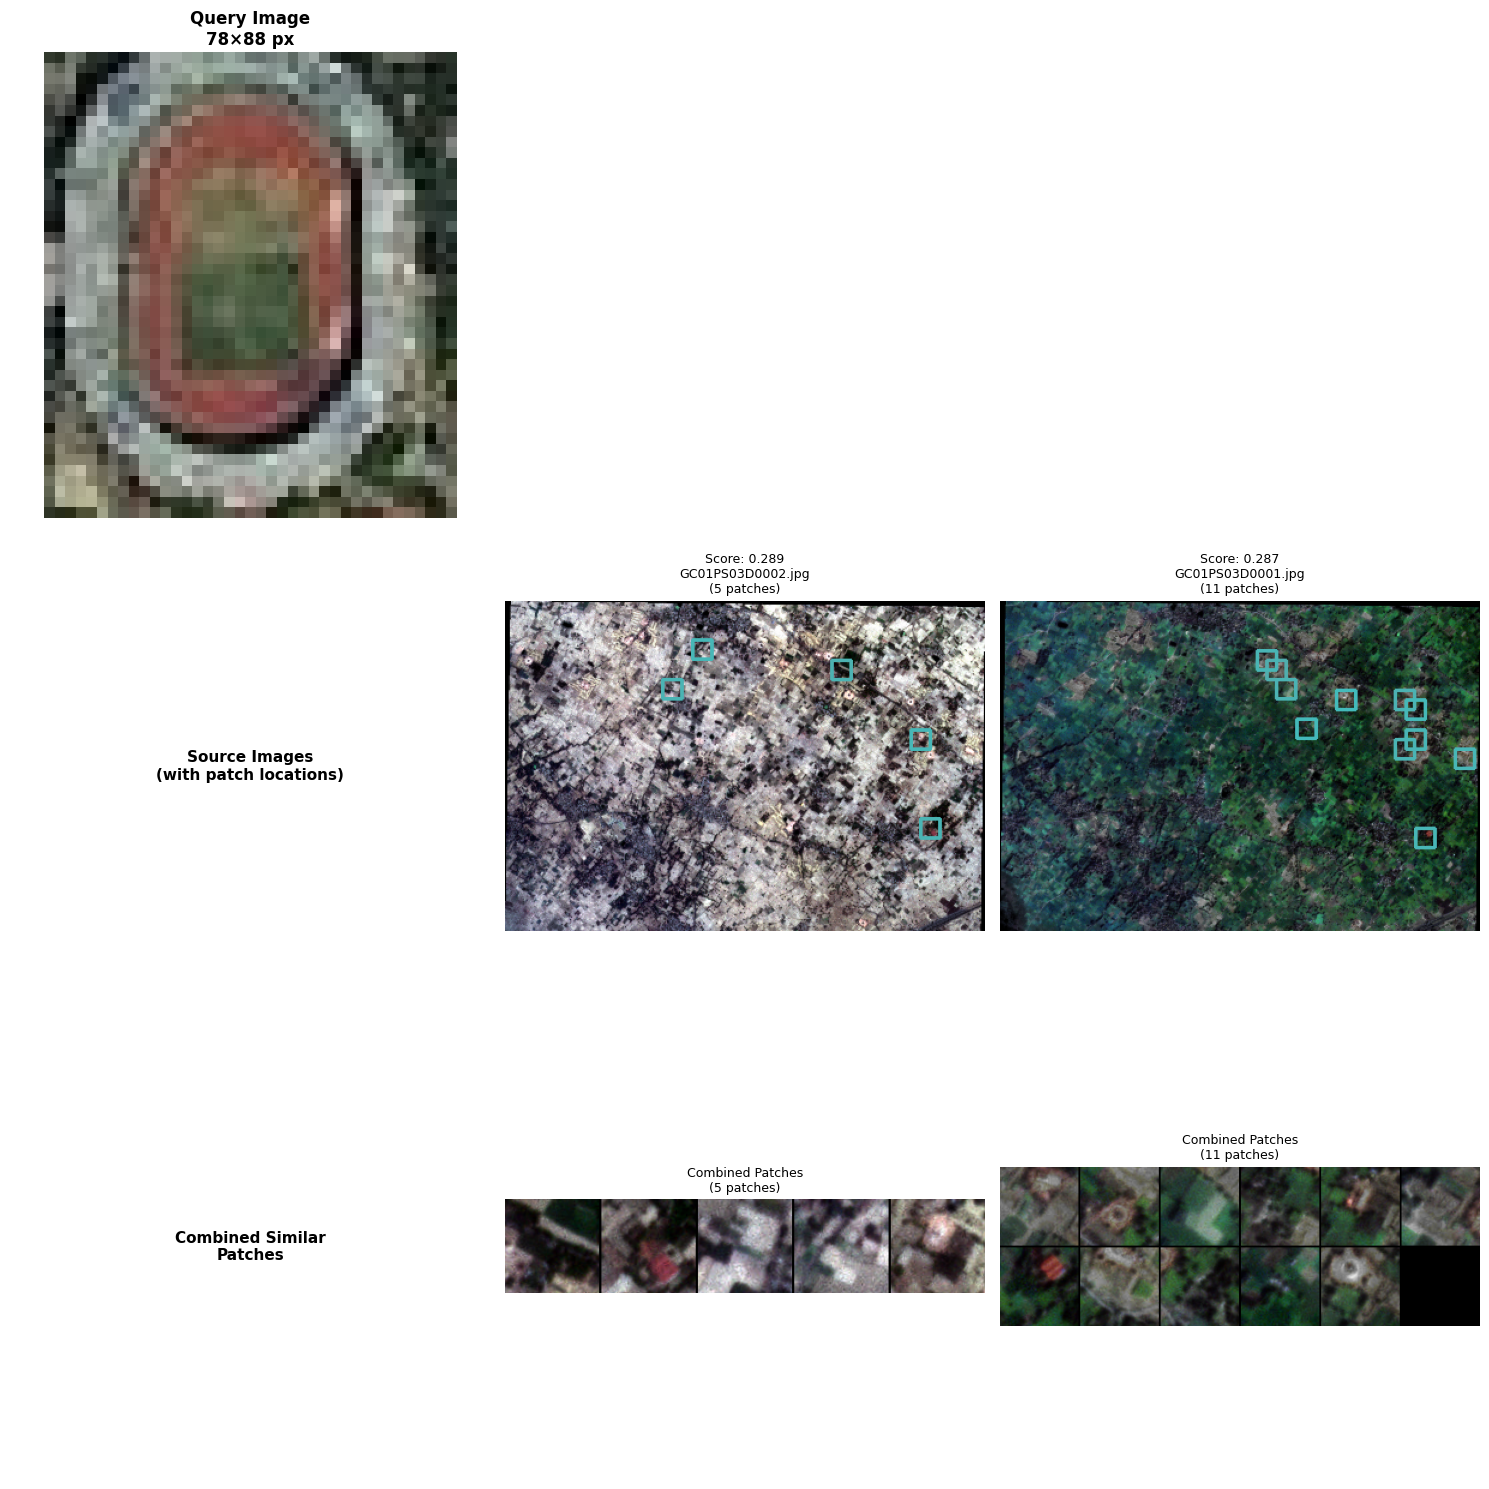


📊 Combined Patches Summary:
   Total images with matches: 2
   1. GC01PS03D0002.jpg: 5 patches, score 0.289
   2. GC01PS03D0001.jpg: 11 patches, score 0.287


In [13]:
def quick_query_with_saved_index(query_image_path: str, index_path: str = "fixed_kernel_index"):
    """Quick function to query using pre-computed index"""

    # Load system with saved index
    system = FixedKernelRetrievalSystem(model_name="dinov3")
    system.load_index(index_path)

    # Search
    results = system.search_with_query(query_image_path, top_k=25)
    filtered_results = system.apply_nms(results, iou_threshold=0.3)

    # Visualize with combined patches
    system.visualize_combined_patches(
        filtered_results,
        query_image=query_image_path,
        max_images_to_show=5
    )

    return filtered_results

# Use it like this:
results = quick_query_with_saved_index("/home/amarjeet/Desktop/Retrieval_engine_for_satellite_images/Untitled_folder/01.png")

Loading DINOv3 model: facebook/dinov3-vitb16-pretrain-lvd1689m
DINOv3 model loaded. Hidden size: 768
Index loaded: 3322 patches, 4 images
Query image resized from 38x44 to 85x98 to match kernel size
Extracted 1 query patches from image of size 85x98
Searching with 1 query patches...
Found 25 results. Top score: 0.4179


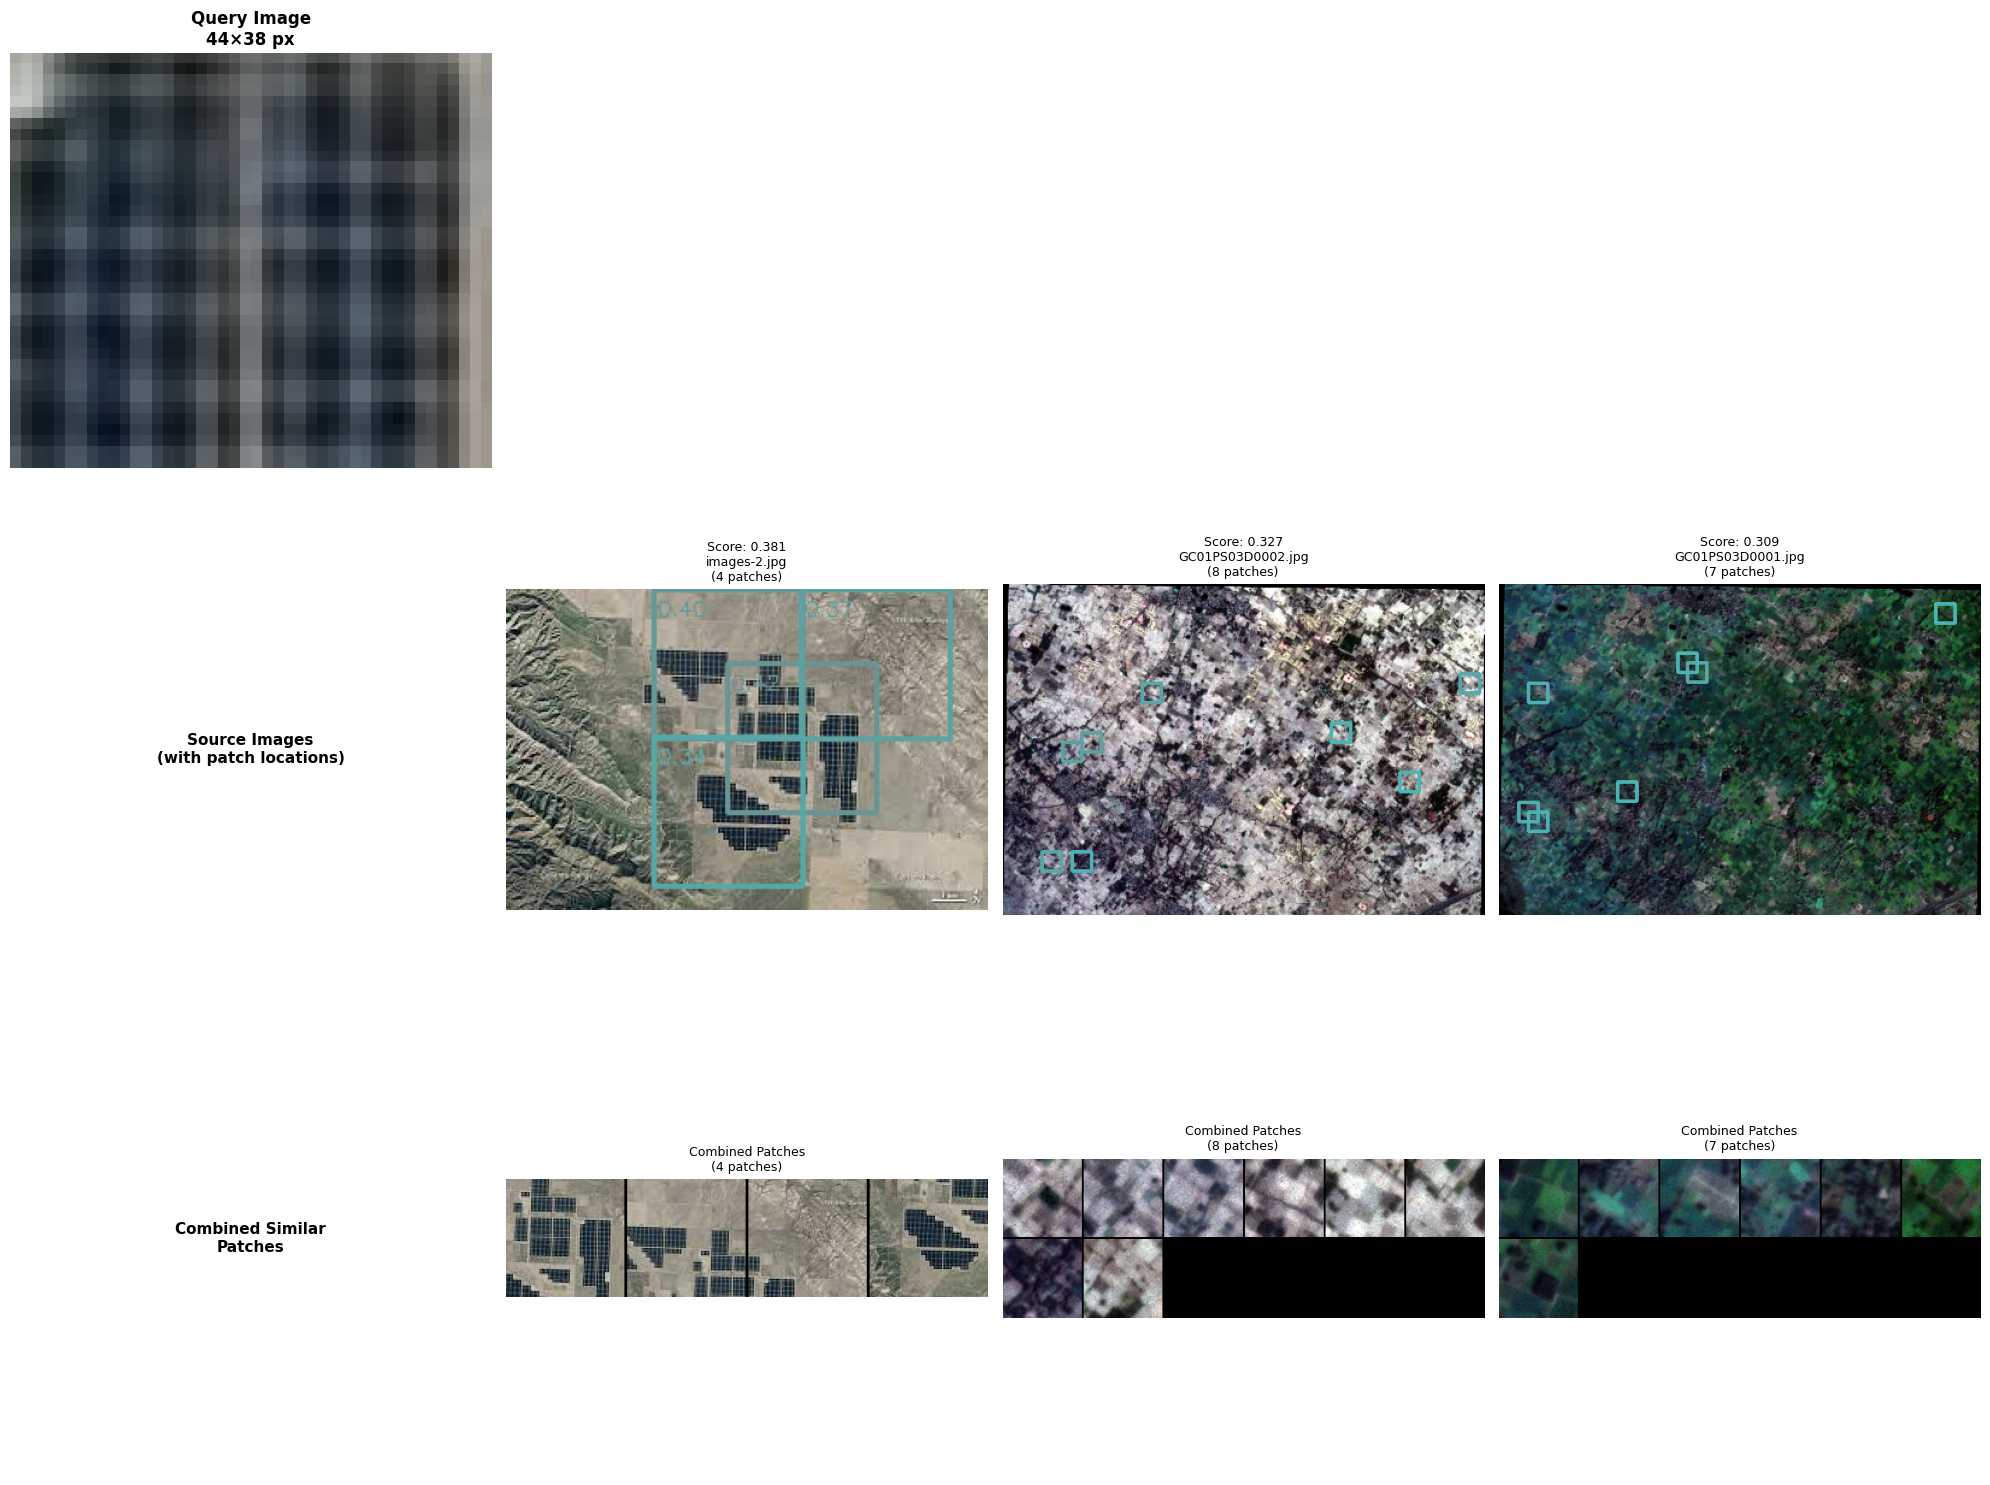


📊 Combined Patches Summary:
   Total images with matches: 3
   1. images-2.jpg: 4 patches, score 0.381
   2. GC01PS03D0002.jpg: 8 patches, score 0.327
   3. GC01PS03D0001.jpg: 7 patches, score 0.309


In [9]:
def quick_query_with_saved_index(query_image_path: str, index_path: str = "fixed_kernel_index"):
    """Quick function to query using pre-computed index"""

    # Load system with saved index
    system = FixedKernelRetrievalSystem(model_name="dinov3")
    system.load_index(index_path)

    # Search
    results = system.search_with_query(query_image_path, top_k=25)
    filtered_results = system.apply_nms(results, iou_threshold=0.3)

    # Visualize with combined patches
    system.visualize_combined_patches(
        filtered_results,
        query_image=query_image_path,
        max_images_to_show=5
    )

    return filtered_results

# Use it like this:
results = quick_query_with_saved_index("/home/amarjeet/Desktop/Retrieval_engine_for_satellite_images/Untitled_folder/04.png")